### dev

In [1]:
import os
import numpy as np
import pandas as pd
import zarr
import glob
import btrack
import cv2
from PIL import Image, ImageDraw, ImageFont
from tqdm.auto import tqdm

In [14]:
# extract single cell df
sc_df_fn = '/mnt/SYNO/macrohet_syno/results/dfs/arx/dt_df.pkl' # time intensive step
df = pd.read_pickle(sc_df_fn)


In [3]:
# Prepare font and color settings
font_path = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"  # Update this path to your font file
font = ImageFont.truetype(font_path, 42)
text_color = (0, 255, 255)  # Yellow color in RGB format
# Define the side length
side_length = 750
# and other image properties
track_scale_factor = 5.04
image_scale_m_per_pixel = 1.4949402023919043e-07
image_scale_um_per_pixel = image_scale_m_per_pixel*1E6
image_width = image_height = 6048
last_seg_fn = []

# Bulk generation

In [47]:
df = df[
    (df['Strain'] == 'RD1') & 
    (df['Compound'].isin(['RIF', 'INH', 'BDQ'])) &
    (df['Concentration'].isin(['EC99']))
]

In [48]:
for unique_ID in tqdm(reversed(df['ID'].unique()), total = len(df['ID'].unique())):
    
    try: 
        if 'ND0003' not in unique_ID:
            continue
        # if os.path.exists(f"/mnt/SYNO/macrohet_syno/glimpses/{unique_ID}.mp4"):
        #     print(f'Path exists {unique_ID}')
        #     continue 
            
        sc_df = df[df['ID'] == unique_ID]
        
        # get the acq id information
        acq_ID = row, column = int(unique_ID.split('.')[1]), int(unique_ID.split('.')[2]) 
        cell_ID = int(unique_ID.split('.')[0])
        expt_ID = unique_ID.split('.')[-1]
        
        # assign the proper channel enumeration
        mphi_channel = 0 if expt_ID == 'PS0000' else 1
        mtb_channel = 1 if expt_ID == 'PS0000' else 0
        
        # if no side length provided then estimate based on max mphi area
        if not side_length:
            # Calculate the side length for cropping based on the square root of the area
            side_length = int(np.sqrt(sc_df['Mphi Area (µm)'].max())) * 2
        
        # preload the images
        image_dir = f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/acquisition/zarr/{acq_ID}.zarr'
        zarr_group = zarr.open(image_dir, mode='r')
        images = zarr_group.images
        sample_image = images[0,0,0,...]
        
        
        # Load segmentation if necessary
        seg_fn = glob.glob(f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/labels/*/{acq_ID}.h5')[0]
        if seg_fn != last_seg_fn:
            with btrack.io.HDF5FileHandler(seg_fn, 'r', obj_type='obj_type_1') as reader:
                segmentation = reader.segmentation
            last_seg_fn = seg_fn
        
        # load the segmentation 
        rgb_stack = []
        
        # iterate over each frame/data point
        for i, t in tqdm(enumerate(sc_df['Time (hours)']), total = len(sc_df), leave = False, desc = f'Creating glimpse {unique_ID}'):
            
            sc_df_t = sc_df[sc_df['Time (hours)'] == t]
            # Extract xy coordinates and transpose for python and area from the cell information
            y_coord, x_coord, area, t, f, mtb = sc_df_t.loc[:, ['x', 'y', 'Mphi Area (µm)', 'Time (hours)', 'Frame', 'Mtb Area (µm)']].values[0]
        
            # Scale according to tracking shrinkage
            y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor
        
            # Calculate the cropping boundaries
            x_start = int(x_coord - side_length / 2)
            x_end = int(x_coord + side_length / 2)
            y_start = int(y_coord - side_length / 2)
            y_end = int(y_coord + side_length / 2)
            
            # Pad the boundaries if they exceed the image dimensions
            if x_start < 0:
                x_pad = abs(x_start)
                x_start = 0
            else:
                x_pad = 0
        
            if x_end > sample_image.shape[0]:
                x_pad_end = x_end - sample_image.shape[0]
                x_end = sample_image.shape[0]
            else:
                x_pad_end = 0
        
            if y_start < 0:
                y_pad = abs(y_start)
                y_start = 0
            else:
                y_pad = 0
        
            if y_end > sample_image.shape[1]:
                y_pad_end = y_end - sample_image.shape[1]
                y_end = sample_image.shape[1]
            else:
                y_pad_end = 0
        
            # Crop the image
            cropped_image = images[int(f), :, 0, x_start:x_end, y_start:y_end]
        
            # Pad the cropped image if necessary
            cropped_image = np.pad(cropped_image, ((0, 0), (x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')
            
            # extract the gfp and rfp channels to apply some vis techn
            gfp = cropped_image[mphi_channel, ...]
            rfp = cropped_image[mtb_channel, ...]
            
            # clip the images so that the contrast is more apparent
            contrast_lim_gfp = np.clip(gfp, 358, 5886)
            contrast_lim_rfp = np.clip(rfp, 480, 1300)
            
            norm_gfp = cv2.normalize(contrast_lim_gfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
            norm_rfp = cv2.normalize(contrast_lim_rfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
            
            # Create an empty RGB image with the same shape as the input image
            rgb_image = np.zeros((contrast_lim_gfp.shape[0], contrast_lim_gfp.shape[1], 3), dtype=np.uint16)
            
            # Assign the first channel to the green channel of the RGB image
            rgb_image[..., 1] = norm_gfp
            
            # Assign the second channel to the red and blue channels of the RGB image to create magenta
            rgb_image[..., 0] = norm_rfp
            rgb_image[..., 2] = norm_rfp
            
            # scale down to 8bit
            rgb_image = np.uint8(rgb_image >> 8)
        
            
            # load mask (singular)
            cropped_masks = segmentation[int(f), x_start:x_end, y_start:y_end]
            
            # Pad the cropped image if necessary
            cropped_masks = np.pad(cropped_masks, ((x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')
        
            # extract only that segment
            seg_ID = cropped_masks[int(cropped_masks.shape[0] / 2), int(cropped_masks.shape[1] / 2)]
           
            if seg_ID == 0:
                instance_mask = np.zeros((side_length, side_length), dtype = np.uint8)
            else:
                instance_mask = (cropped_masks == seg_ID).astype(np.uint8)
        
            # draw outline
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(rgb_image, contours, -1, (0, 2 ** 8, 2 ** 8), thickness=2)  # make 8bit
            
            # Convert to PIL image for text overlay
            pil_image = Image.fromarray(rgb_image)
            draw = ImageDraw.Draw(pil_image)
        
            # Bottom left corner text
            bottom_left_text = f"{t} hours"
            draw.text((10, rgb_image.shape[0] - 80), bottom_left_text, font=font, fill=text_color)
        
            # Bottom right corner text
            bottom_right_text = '20µm'
            text_size = font.getbbox(bottom_right_text)
            text_width = text_size[2] - text_size[0]  # Calculate text width
            bottom_right_text_position = (rgb_image.shape[1] - text_width - 40, rgb_image.shape[0] - 80)
            draw.text(bottom_right_text_position, bottom_right_text, font=font, fill=text_color)
        
            # Calculate line length in pixels for a 20 micrometer scale bar
            line_length_pixels = int(20 / image_scale_um_per_pixel)
            line_start = (bottom_right_text_position[0], bottom_right_text_position[1] + 55)
            line_end = (line_start[0] + line_length_pixels, line_start[1])
            draw.line([line_start, line_end], fill=text_color, width=10)
        
            # Top left corner text
            draw.text((10, 10), unique_ID, font=font, fill=text_color)
        
            # Top right corner text
            mtb_value = f"Mtb:{mtb:.2f}µm²"
            text_size = font.getbbox(mtb_value)
            text_width = text_size[2] - text_size[0]  # Calculate text width
            top_right_text_position = (rgb_image.shape[1] - text_width - 10, 10)
            draw.text(top_right_text_position, mtb_value, font=font, fill=text_color)
        
            # Convert back to OpenCV image
            rgb_image = np.array(pil_image)
            
            # Resize image to consistent shape
            rgb_image_resized = cv2.resize(rgb_image, (side_length, side_length), interpolation=cv2.INTER_AREA)

            # add to stack
            rgb_stack.append(rgb_image_resized)
    
        # compile into array
        rgb_stack = np.stack(rgb_stack, axis = 0)
        
        # Get the dimensions of the first frame
        height, width, _ = rgb_stack[0].shape
        
        # Define the frame rate (number of frames per second)
        frame_rate = len(rgb_stack) / 20  # Total frames divided by total seconds
        output_file = f"/mnt/SYNO/macrohet_syno/results/glimpse_dt_graphs/glimpses/{unique_ID}.mp4"
        # Initialize VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_file, fourcc, frame_rate, (width, height))
        
        # Write each frame to the video file
        for frame in rgb_stack:
            out.write(frame)
        
        # Release the VideoWriter object
        out.release()
        
        print(f"Video {unique_ID} saved successfully.")

    except Exception as e:
        error_message = f"Error: {e}\nUnique ID: {unique_ID}\n"
        with open("error_log.txt", "a") as file:
            file.write(error_message)
        

  0%|          | 0/964 [00:00<?, ?it/s]

Creating glimpse 1874.6.12.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 1874.6.12.ND0003 saved successfully.


Creating glimpse 1822.6.12.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 1822.6.12.ND0003 saved successfully.


Creating glimpse 1815.6.12.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 1815.6.12.ND0003 saved successfully.


Creating glimpse 1803.6.12.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 1803.6.12.ND0003 saved successfully.


Creating glimpse 1796.6.12.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 1796.6.12.ND0003 saved successfully.


Creating glimpse 1672.6.12.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 1672.6.12.ND0003 saved successfully.


Creating glimpse 1650.6.12.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 1650.6.12.ND0003 saved successfully.


Creating glimpse 1622.6.12.ND0003:   0%|          | 0/98 [00:00<?, ?it/s]

Video 1622.6.12.ND0003 saved successfully.


Creating glimpse 1587.6.12.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 1587.6.12.ND0003 saved successfully.


Creating glimpse 1516.6.12.ND0003:   0%|          | 0/105 [00:00<?, ?it/s]

Video 1516.6.12.ND0003 saved successfully.


Creating glimpse 1496.6.12.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 1496.6.12.ND0003 saved successfully.


Creating glimpse 1462.6.12.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 1462.6.12.ND0003 saved successfully.


Creating glimpse 1449.6.12.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 1449.6.12.ND0003 saved successfully.


Creating glimpse 1454.6.12.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 1454.6.12.ND0003 saved successfully.


Creating glimpse 1429.6.12.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 1429.6.12.ND0003 saved successfully.


Creating glimpse 1403.6.12.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 1403.6.12.ND0003 saved successfully.


Creating glimpse 1417.6.12.ND0003:   0%|          | 0/112 [00:00<?, ?it/s]

Video 1417.6.12.ND0003 saved successfully.


Creating glimpse 1384.6.12.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 1384.6.12.ND0003 saved successfully.


Creating glimpse 1321.6.12.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 1321.6.12.ND0003 saved successfully.


Creating glimpse 1314.6.12.ND0003:   0%|          | 0/117 [00:00<?, ?it/s]

Video 1314.6.12.ND0003 saved successfully.


Creating glimpse 1197.6.12.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 1197.6.12.ND0003 saved successfully.


Creating glimpse 1175.6.12.ND0003:   0%|          | 0/117 [00:00<?, ?it/s]

Video 1175.6.12.ND0003 saved successfully.


Creating glimpse 1135.6.12.ND0003:   0%|          | 0/98 [00:00<?, ?it/s]

Video 1135.6.12.ND0003 saved successfully.


Creating glimpse 1101.6.12.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 1101.6.12.ND0003 saved successfully.


Creating glimpse 1057.6.12.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 1057.6.12.ND0003 saved successfully.


Creating glimpse 1022.6.12.ND0003:   0%|          | 0/109 [00:00<?, ?it/s]

Video 1022.6.12.ND0003 saved successfully.


Creating glimpse 970.6.12.ND0003:   0%|          | 0/132 [00:00<?, ?it/s]

Video 970.6.12.ND0003 saved successfully.


Creating glimpse 948.6.12.ND0003:   0%|          | 0/97 [00:00<?, ?it/s]

Video 948.6.12.ND0003 saved successfully.


Creating glimpse 815.6.12.ND0003:   0%|          | 0/132 [00:00<?, ?it/s]

Video 815.6.12.ND0003 saved successfully.


Creating glimpse 810.6.12.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 810.6.12.ND0003 saved successfully.


Creating glimpse 726.6.12.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 726.6.12.ND0003 saved successfully.


Creating glimpse 664.6.12.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 664.6.12.ND0003 saved successfully.


Creating glimpse 646.6.12.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 646.6.12.ND0003 saved successfully.


Creating glimpse 536.6.12.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 536.6.12.ND0003 saved successfully.


Creating glimpse 513.6.12.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 513.6.12.ND0003 saved successfully.


Creating glimpse 464.6.12.ND0003:   0%|          | 0/123 [00:00<?, ?it/s]

Video 464.6.12.ND0003 saved successfully.


Creating glimpse 477.6.12.ND0003:   0%|          | 0/149 [00:00<?, ?it/s]

Video 477.6.12.ND0003 saved successfully.


Creating glimpse 393.6.12.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 393.6.12.ND0003 saved successfully.


Creating glimpse 412.6.12.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 412.6.12.ND0003 saved successfully.


Creating glimpse 308.6.12.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 308.6.12.ND0003 saved successfully.


Creating glimpse 258.6.12.ND0003:   0%|          | 0/115 [00:00<?, ?it/s]

Video 258.6.12.ND0003 saved successfully.


Creating glimpse 253.6.12.ND0003:   0%|          | 0/140 [00:00<?, ?it/s]

Video 253.6.12.ND0003 saved successfully.


Creating glimpse 250.6.12.ND0003:   0%|          | 0/136 [00:00<?, ?it/s]

Video 250.6.12.ND0003 saved successfully.


Creating glimpse 83.6.12.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 83.6.12.ND0003 saved successfully.


Creating glimpse 74.6.12.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 74.6.12.ND0003 saved successfully.


Creating glimpse 123.6.12.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 123.6.12.ND0003 saved successfully.


Creating glimpse 119.6.12.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 119.6.12.ND0003 saved successfully.


Creating glimpse 105.6.12.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 105.6.12.ND0003 saved successfully.


Creating glimpse 96.6.12.ND0003:   0%|          | 0/150 [00:00<?, ?it/s]

Video 96.6.12.ND0003 saved successfully.


Creating glimpse 20.6.12.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 20.6.12.ND0003 saved successfully.


Creating glimpse 17.6.12.ND0003:   0%|          | 0/120 [00:00<?, ?it/s]

Video 17.6.12.ND0003 saved successfully.


Creating glimpse 45.6.12.ND0003:   0%|          | 0/121 [00:00<?, ?it/s]

Video 45.6.12.ND0003 saved successfully.


Creating glimpse 42.6.12.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 42.6.12.ND0003 saved successfully.


Creating glimpse 41.6.12.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 41.6.12.ND0003 saved successfully.


Creating glimpse 39.6.12.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 39.6.12.ND0003 saved successfully.


Creating glimpse 2.6.12.ND0003:   0%|          | 0/145 [00:00<?, ?it/s]

Video 2.6.12.ND0003 saved successfully.


Creating glimpse 188.6.12.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 188.6.12.ND0003 saved successfully.


Creating glimpse 245.6.12.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 245.6.12.ND0003 saved successfully.


Creating glimpse 241.6.12.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 241.6.12.ND0003 saved successfully.


Creating glimpse 240.6.12.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 240.6.12.ND0003 saved successfully.


Creating glimpse 219.6.12.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 219.6.12.ND0003 saved successfully.


Creating glimpse 234.6.12.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 234.6.12.ND0003 saved successfully.


Creating glimpse 140.6.12.ND0003:   0%|          | 0/148 [00:00<?, ?it/s]

Video 140.6.12.ND0003 saved successfully.


Creating glimpse 126.6.12.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 126.6.12.ND0003 saved successfully.


Creating glimpse 176.6.12.ND0003:   0%|          | 0/138 [00:00<?, ?it/s]

Video 176.6.12.ND0003 saved successfully.


Creating glimpse 167.6.12.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 167.6.12.ND0003 saved successfully.


Creating glimpse 161.6.12.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 161.6.12.ND0003 saved successfully.


[INFO][2024/09/10 11:53:21 AM] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 11).h5...
[INFO][2024/09/10 11:54:13 AM] Loading segmentation (154, 6048, 6048)
[INFO][2024/09/10 11:54:13 AM] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 11).h5


Creating glimpse 2177.6.11.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2177.6.11.ND0003 saved successfully.


Creating glimpse 2198.6.11.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2198.6.11.ND0003 saved successfully.


Creating glimpse 2137.6.11.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 2137.6.11.ND0003 saved successfully.


Creating glimpse 2122.6.11.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2122.6.11.ND0003 saved successfully.


Creating glimpse 1995.6.11.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 1995.6.11.ND0003 saved successfully.


Creating glimpse 2008.6.11.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 2008.6.11.ND0003 saved successfully.


Creating glimpse 1974.6.11.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 1974.6.11.ND0003 saved successfully.


Creating glimpse 1970.6.11.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 1970.6.11.ND0003 saved successfully.


Creating glimpse 1929.6.11.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 1929.6.11.ND0003 saved successfully.


Creating glimpse 1809.6.11.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 1809.6.11.ND0003 saved successfully.


Creating glimpse 1822.6.11.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 1822.6.11.ND0003 saved successfully.


Creating glimpse 1768.6.11.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 1768.6.11.ND0003 saved successfully.


Creating glimpse 1770.6.11.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 1770.6.11.ND0003 saved successfully.


Creating glimpse 1773.6.11.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 1773.6.11.ND0003 saved successfully.


Creating glimpse 1711.6.11.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 1711.6.11.ND0003 saved successfully.


Creating glimpse 1705.6.11.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 1705.6.11.ND0003 saved successfully.


Creating glimpse 1707.6.11.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 1707.6.11.ND0003 saved successfully.


Creating glimpse 1667.6.11.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 1667.6.11.ND0003 saved successfully.


Creating glimpse 1635.6.11.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 1635.6.11.ND0003 saved successfully.


Creating glimpse 1581.6.11.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 1581.6.11.ND0003 saved successfully.


Creating glimpse 1587.6.11.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 1587.6.11.ND0003 saved successfully.


Creating glimpse 1554.6.11.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 1554.6.11.ND0003 saved successfully.


Creating glimpse 1549.6.11.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1549.6.11.ND0003 saved successfully.


Creating glimpse 1562.6.11.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 1562.6.11.ND0003 saved successfully.


Creating glimpse 1529.6.11.ND0003:   0%|          | 0/108 [00:00<?, ?it/s]

Video 1529.6.11.ND0003 saved successfully.


Creating glimpse 1533.6.11.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 1533.6.11.ND0003 saved successfully.


Creating glimpse 1474.6.11.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 1474.6.11.ND0003 saved successfully.


Creating glimpse 1403.6.11.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 1403.6.11.ND0003 saved successfully.


Creating glimpse 1415.6.11.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 1415.6.11.ND0003 saved successfully.


Creating glimpse 1387.6.11.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 1387.6.11.ND0003 saved successfully.


Creating glimpse 1399.6.11.ND0003:   0%|          | 0/115 [00:00<?, ?it/s]

Video 1399.6.11.ND0003 saved successfully.


Creating glimpse 1342.6.11.ND0003:   0%|          | 0/116 [00:00<?, ?it/s]

Video 1342.6.11.ND0003 saved successfully.


Creating glimpse 1332.6.11.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 1332.6.11.ND0003 saved successfully.


Creating glimpse 1312.6.11.ND0003:   0%|          | 0/119 [00:00<?, ?it/s]

Video 1312.6.11.ND0003 saved successfully.


Creating glimpse 1301.6.11.ND0003:   0%|          | 0/120 [00:00<?, ?it/s]

Video 1301.6.11.ND0003 saved successfully.


Creating glimpse 1265.6.11.ND0003:   0%|          | 0/120 [00:00<?, ?it/s]

Video 1265.6.11.ND0003 saved successfully.


Creating glimpse 1204.6.11.ND0003:   0%|          | 0/123 [00:00<?, ?it/s]

Video 1204.6.11.ND0003 saved successfully.


Creating glimpse 1217.6.11.ND0003:   0%|          | 0/122 [00:00<?, ?it/s]

Video 1217.6.11.ND0003 saved successfully.


Creating glimpse 1220.6.11.ND0003:   0%|          | 0/123 [00:00<?, ?it/s]

Video 1220.6.11.ND0003 saved successfully.


Creating glimpse 1191.6.11.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1191.6.11.ND0003 saved successfully.


Creating glimpse 1162.6.11.ND0003:   0%|          | 0/125 [00:00<?, ?it/s]

Video 1162.6.11.ND0003 saved successfully.


Creating glimpse 1160.6.11.ND0003:   0%|          | 0/125 [00:00<?, ?it/s]

Video 1160.6.11.ND0003 saved successfully.


Creating glimpse 1081.6.11.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 1081.6.11.ND0003 saved successfully.


Creating glimpse 1095.6.11.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 1095.6.11.ND0003 saved successfully.


Creating glimpse 1041.6.11.ND0003:   0%|          | 0/128 [00:00<?, ?it/s]

Video 1041.6.11.ND0003 saved successfully.


Creating glimpse 1038.6.11.ND0003:   0%|          | 0/116 [00:00<?, ?it/s]

Video 1038.6.11.ND0003 saved successfully.


Creating glimpse 1067.6.11.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 1067.6.11.ND0003 saved successfully.


Creating glimpse 1060.6.11.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 1060.6.11.ND0003 saved successfully.


Creating glimpse 1023.6.11.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 1023.6.11.ND0003 saved successfully.


Creating glimpse 1017.6.11.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 1017.6.11.ND0003 saved successfully.


Creating glimpse 991.6.11.ND0003:   0%|          | 0/130 [00:00<?, ?it/s]

Video 991.6.11.ND0003 saved successfully.


Creating glimpse 806.6.11.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 806.6.11.ND0003 saved successfully.


Creating glimpse 783.6.11.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 783.6.11.ND0003 saved successfully.


Creating glimpse 670.6.11.ND0003:   0%|          | 0/141 [00:00<?, ?it/s]

Video 670.6.11.ND0003 saved successfully.


Creating glimpse 596.6.11.ND0003:   0%|          | 0/143 [00:00<?, ?it/s]

Video 596.6.11.ND0003 saved successfully.


Creating glimpse 609.6.11.ND0003:   0%|          | 0/144 [00:00<?, ?it/s]

Video 609.6.11.ND0003 saved successfully.


Creating glimpse 535.6.11.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 535.6.11.ND0003 saved successfully.


Creating glimpse 483.6.11.ND0003:   0%|          | 0/147 [00:00<?, ?it/s]

Video 483.6.11.ND0003 saved successfully.


Creating glimpse 416.6.11.ND0003:   0%|          | 0/149 [00:00<?, ?it/s]

Video 416.6.11.ND0003 saved successfully.


Creating glimpse 390.6.11.ND0003:   0%|          | 0/105 [00:00<?, ?it/s]

Video 390.6.11.ND0003 saved successfully.


Creating glimpse 289.6.11.ND0003:   0%|          | 0/121 [00:00<?, ?it/s]

Video 289.6.11.ND0003 saved successfully.


Creating glimpse 80.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 80.6.11.ND0003 saved successfully.


Creating glimpse 87.6.11.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 87.6.11.ND0003 saved successfully.


Creating glimpse 89.6.11.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 89.6.11.ND0003 saved successfully.


Creating glimpse 115.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 115.6.11.ND0003 saved successfully.


Creating glimpse 112.6.11.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 112.6.11.ND0003 saved successfully.


Creating glimpse 111.6.11.ND0003:   0%|          | 0/148 [00:00<?, ?it/s]

Video 111.6.11.ND0003 saved successfully.


Creating glimpse 108.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 108.6.11.ND0003 saved successfully.


Creating glimpse 61.6.11.ND0003:   0%|          | 0/77 [00:00<?, ?it/s]

Video 61.6.11.ND0003 saved successfully.


Creating glimpse 90.6.11.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 90.6.11.ND0003 saved successfully.


Creating glimpse 24.6.11.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 24.6.11.ND0003 saved successfully.


Creating glimpse 52.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 52.6.11.ND0003 saved successfully.


Creating glimpse 47.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 47.6.11.ND0003 saved successfully.


Creating glimpse 34.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 34.6.11.ND0003 saved successfully.


Creating glimpse 33.6.11.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 33.6.11.ND0003 saved successfully.


Creating glimpse 195.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 195.6.11.ND0003 saved successfully.


Creating glimpse 185.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 185.6.11.ND0003 saved successfully.


Creating glimpse 179.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 179.6.11.ND0003 saved successfully.


Creating glimpse 178.6.11.ND0003:   0%|          | 0/114 [00:00<?, ?it/s]

Video 178.6.11.ND0003 saved successfully.


Creating glimpse 222.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 222.6.11.ND0003 saved successfully.


Creating glimpse 205.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 205.6.11.ND0003 saved successfully.


Creating glimpse 216.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 216.6.11.ND0003 saved successfully.


Creating glimpse 220.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 220.6.11.ND0003 saved successfully.


Creating glimpse 140.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 140.6.11.ND0003 saved successfully.


Creating glimpse 129.6.11.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 129.6.11.ND0003 saved successfully.


Creating glimpse 118.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 118.6.11.ND0003 saved successfully.


Creating glimpse 174.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 174.6.11.ND0003 saved successfully.


Creating glimpse 167.6.11.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 167.6.11.ND0003 saved successfully.


[INFO][2024/09/10 12:18:43 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 10).h5...
[INFO][2024/09/10 12:19:40 PM] Loading segmentation (154, 6048, 6048)
[INFO][2024/09/10 12:19:41 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 10).h5


Creating glimpse 2786.6.10.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 2786.6.10.ND0003 saved successfully.


Creating glimpse 2764.6.10.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2764.6.10.ND0003 saved successfully.


Creating glimpse 2771.6.10.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2771.6.10.ND0003 saved successfully.


Creating glimpse 2720.6.10.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2720.6.10.ND0003 saved successfully.


Creating glimpse 2723.6.10.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2723.6.10.ND0003 saved successfully.


Creating glimpse 2725.6.10.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2725.6.10.ND0003 saved successfully.


Creating glimpse 2685.6.10.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 2685.6.10.ND0003 saved successfully.


Creating glimpse 2683.6.10.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 2683.6.10.ND0003 saved successfully.


Creating glimpse 2675.6.10.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 2675.6.10.ND0003 saved successfully.


Creating glimpse 2620.6.10.ND0003:   0%|          | 0/77 [00:00<?, ?it/s]

Video 2620.6.10.ND0003 saved successfully.


Creating glimpse 2616.6.10.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 2616.6.10.ND0003 saved successfully.


Creating glimpse 2634.6.10.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2634.6.10.ND0003 saved successfully.


Creating glimpse 2612.6.10.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 2612.6.10.ND0003 saved successfully.


Creating glimpse 2577.6.10.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 2577.6.10.ND0003 saved successfully.


Creating glimpse 2590.6.10.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 2590.6.10.ND0003 saved successfully.


Creating glimpse 2565.6.10.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 2565.6.10.ND0003 saved successfully.


Creating glimpse 2535.6.10.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 2535.6.10.ND0003 saved successfully.


Creating glimpse 2540.6.10.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 2540.6.10.ND0003 saved successfully.


Creating glimpse 2550.6.10.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 2550.6.10.ND0003 saved successfully.


Creating glimpse 2508.6.10.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 2508.6.10.ND0003 saved successfully.


Creating glimpse 2474.6.10.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2474.6.10.ND0003 saved successfully.


Creating glimpse 2456.6.10.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 2456.6.10.ND0003 saved successfully.


Creating glimpse 2434.6.10.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 2434.6.10.ND0003 saved successfully.


Creating glimpse 2400.6.10.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2400.6.10.ND0003 saved successfully.


Creating glimpse 2409.6.10.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 2409.6.10.ND0003 saved successfully.


Creating glimpse 2405.6.10.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 2405.6.10.ND0003 saved successfully.


Creating glimpse 2418.6.10.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 2418.6.10.ND0003 saved successfully.


Creating glimpse 2387.6.10.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 2387.6.10.ND0003 saved successfully.


Creating glimpse 2389.6.10.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 2389.6.10.ND0003 saved successfully.


Creating glimpse 2391.6.10.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 2391.6.10.ND0003 saved successfully.


Creating glimpse 2363.6.10.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 2363.6.10.ND0003 saved successfully.


Creating glimpse 2335.6.10.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2335.6.10.ND0003 saved successfully.


Creating glimpse 2309.6.10.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 2309.6.10.ND0003 saved successfully.


Creating glimpse 2316.6.10.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 2316.6.10.ND0003 saved successfully.


Creating glimpse 2303.6.10.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 2303.6.10.ND0003 saved successfully.


Creating glimpse 2271.6.10.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2271.6.10.ND0003 saved successfully.


Creating glimpse 2261.6.10.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2261.6.10.ND0003 saved successfully.


Creating glimpse 2264.6.10.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 2264.6.10.ND0003 saved successfully.


Creating glimpse 2239.6.10.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2239.6.10.ND0003 saved successfully.


Creating glimpse 2230.6.10.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 2230.6.10.ND0003 saved successfully.


Creating glimpse 2169.6.10.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 2169.6.10.ND0003 saved successfully.


Creating glimpse 2171.6.10.ND0003:   0%|          | 0/98 [00:00<?, ?it/s]

Video 2171.6.10.ND0003 saved successfully.


Creating glimpse 2161.6.10.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 2161.6.10.ND0003 saved successfully.


Creating glimpse 2120.6.10.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2120.6.10.ND0003 saved successfully.


Creating glimpse 2090.6.10.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 2090.6.10.ND0003 saved successfully.


Creating glimpse 2111.6.10.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 2111.6.10.ND0003 saved successfully.


Creating glimpse 2078.6.10.ND0003:   0%|          | 0/102 [00:00<?, ?it/s]

Video 2078.6.10.ND0003 saved successfully.


Creating glimpse 2004.6.10.ND0003:   0%|          | 0/105 [00:00<?, ?it/s]

Video 2004.6.10.ND0003 saved successfully.


Creating glimpse 1967.6.10.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 1967.6.10.ND0003 saved successfully.


Creating glimpse 1930.6.10.ND0003:   0%|          | 0/108 [00:00<?, ?it/s]

Video 1930.6.10.ND0003 saved successfully.


Creating glimpse 1901.6.10.ND0003:   0%|          | 0/109 [00:00<?, ?it/s]

Video 1901.6.10.ND0003 saved successfully.


Creating glimpse 1906.6.10.ND0003:   0%|          | 0/109 [00:00<?, ?it/s]

Video 1906.6.10.ND0003 saved successfully.


Creating glimpse 1885.6.10.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 1885.6.10.ND0003 saved successfully.


Creating glimpse 1861.6.10.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 1861.6.10.ND0003 saved successfully.


Creating glimpse 1857.6.10.ND0003:   0%|          | 0/111 [00:00<?, ?it/s]

Video 1857.6.10.ND0003 saved successfully.


Creating glimpse 1807.6.10.ND0003:   0%|          | 0/109 [00:00<?, ?it/s]

Video 1807.6.10.ND0003 saved successfully.


Creating glimpse 1820.6.10.ND0003:   0%|          | 0/111 [00:00<?, ?it/s]

Video 1820.6.10.ND0003 saved successfully.


Creating glimpse 1759.6.10.ND0003:   0%|          | 0/114 [00:00<?, ?it/s]

Video 1759.6.10.ND0003 saved successfully.


Creating glimpse 1757.6.10.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 1757.6.10.ND0003 saved successfully.


Creating glimpse 1756.6.10.ND0003:   0%|          | 0/114 [00:00<?, ?it/s]

Video 1756.6.10.ND0003 saved successfully.


Creating glimpse 1722.6.10.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 1722.6.10.ND0003 saved successfully.


Creating glimpse 1733.6.10.ND0003:   0%|          | 0/115 [00:00<?, ?it/s]

Video 1733.6.10.ND0003 saved successfully.


Creating glimpse 1667.6.10.ND0003:   0%|          | 0/117 [00:00<?, ?it/s]

Video 1667.6.10.ND0003 saved successfully.


Creating glimpse 1631.6.10.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 1631.6.10.ND0003 saved successfully.


Creating glimpse 1654.6.10.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 1654.6.10.ND0003 saved successfully.


Creating glimpse 1651.6.10.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 1651.6.10.ND0003 saved successfully.


Creating glimpse 1645.6.10.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 1645.6.10.ND0003 saved successfully.


Creating glimpse 1528.6.10.ND0003:   0%|          | 0/121 [00:00<?, ?it/s]

Video 1528.6.10.ND0003 saved successfully.


Creating glimpse 1522.6.10.ND0003:   0%|          | 0/108 [00:00<?, ?it/s]

Video 1522.6.10.ND0003 saved successfully.


Creating glimpse 1516.6.10.ND0003:   0%|          | 0/122 [00:00<?, ?it/s]

Video 1516.6.10.ND0003 saved successfully.


Creating glimpse 1468.6.10.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 1468.6.10.ND0003 saved successfully.


Creating glimpse 1446.6.10.ND0003:   0%|          | 0/124 [00:00<?, ?it/s]

Video 1446.6.10.ND0003 saved successfully.


Creating glimpse 1435.6.10.ND0003:   0%|          | 0/125 [00:00<?, ?it/s]

Video 1435.6.10.ND0003 saved successfully.


Creating glimpse 1381.6.10.ND0003:   0%|          | 0/126 [00:00<?, ?it/s]

Video 1381.6.10.ND0003 saved successfully.


Creating glimpse 1402.6.10.ND0003:   0%|          | 0/126 [00:00<?, ?it/s]

Video 1402.6.10.ND0003 saved successfully.


Creating glimpse 1395.6.10.ND0003:   0%|          | 0/126 [00:00<?, ?it/s]

Video 1395.6.10.ND0003 saved successfully.


Creating glimpse 1344.6.10.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 1344.6.10.ND0003 saved successfully.


Creating glimpse 1302.6.10.ND0003:   0%|          | 0/128 [00:00<?, ?it/s]

Video 1302.6.10.ND0003 saved successfully.


Creating glimpse 1299.6.10.ND0003:   0%|          | 0/128 [00:00<?, ?it/s]

Video 1299.6.10.ND0003 saved successfully.


Creating glimpse 1298.6.10.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 1298.6.10.ND0003 saved successfully.


Creating glimpse 1327.6.10.ND0003:   0%|          | 0/128 [00:00<?, ?it/s]

Video 1327.6.10.ND0003 saved successfully.


Creating glimpse 1286.6.10.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 1286.6.10.ND0003 saved successfully.


Creating glimpse 1229.6.10.ND0003:   0%|          | 0/130 [00:00<?, ?it/s]

Video 1229.6.10.ND0003 saved successfully.


Creating glimpse 1203.6.10.ND0003:   0%|          | 0/130 [00:00<?, ?it/s]

Video 1203.6.10.ND0003 saved successfully.


Creating glimpse 1156.6.10.ND0003:   0%|          | 0/132 [00:00<?, ?it/s]

Video 1156.6.10.ND0003 saved successfully.


Creating glimpse 1171.6.10.ND0003:   0%|          | 0/132 [00:00<?, ?it/s]

Video 1171.6.10.ND0003 saved successfully.


Creating glimpse 1120.6.10.ND0003:   0%|          | 0/112 [00:00<?, ?it/s]

Video 1120.6.10.ND0003 saved successfully.


Creating glimpse 1110.6.10.ND0003:   0%|          | 0/132 [00:00<?, ?it/s]

Video 1110.6.10.ND0003 saved successfully.


Creating glimpse 1074.6.10.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 1074.6.10.ND0003 saved successfully.


Creating glimpse 1070.6.10.ND0003:   0%|          | 0/135 [00:00<?, ?it/s]

Video 1070.6.10.ND0003 saved successfully.


Creating glimpse 1098.6.10.ND0003:   0%|          | 0/135 [00:00<?, ?it/s]

Video 1098.6.10.ND0003 saved successfully.


Creating glimpse 1093.6.10.ND0003:   0%|          | 0/135 [00:00<?, ?it/s]

Video 1093.6.10.ND0003 saved successfully.


Creating glimpse 1024.6.10.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 1024.6.10.ND0003 saved successfully.


Creating glimpse 1015.6.10.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 1015.6.10.ND0003 saved successfully.


Creating glimpse 942.6.10.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 942.6.10.ND0003 saved successfully.


Creating glimpse 900.6.10.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 900.6.10.ND0003 saved successfully.


Creating glimpse 882.6.10.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 882.6.10.ND0003 saved successfully.


Creating glimpse 871.6.10.ND0003:   0%|          | 0/141 [00:00<?, ?it/s]

Video 871.6.10.ND0003 saved successfully.


Creating glimpse 683.6.10.ND0003:   0%|          | 0/128 [00:00<?, ?it/s]

Video 683.6.10.ND0003 saved successfully.


Creating glimpse 713.6.10.ND0003:   0%|          | 0/145 [00:00<?, ?it/s]

Video 713.6.10.ND0003 saved successfully.


Creating glimpse 644.6.10.ND0003:   0%|          | 0/146 [00:00<?, ?it/s]

Video 644.6.10.ND0003 saved successfully.


Creating glimpse 625.6.10.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 625.6.10.ND0003 saved successfully.


Creating glimpse 624.6.10.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 624.6.10.ND0003 saved successfully.


Creating glimpse 588.6.10.ND0003:   0%|          | 0/148 [00:00<?, ?it/s]

Video 588.6.10.ND0003 saved successfully.


Creating glimpse 554.6.10.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 554.6.10.ND0003 saved successfully.


Creating glimpse 503.6.10.ND0003:   0%|          | 0/150 [00:00<?, ?it/s]

Video 503.6.10.ND0003 saved successfully.


Creating glimpse 399.6.10.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 399.6.10.ND0003 saved successfully.


Creating glimpse 406.6.10.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 406.6.10.ND0003 saved successfully.


Creating glimpse 297.6.10.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 297.6.10.ND0003 saved successfully.


Creating glimpse 288.6.10.ND0003:   0%|          | 0/133 [00:00<?, ?it/s]

Video 288.6.10.ND0003 saved successfully.


Creating glimpse 333.6.10.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 333.6.10.ND0003 saved successfully.


Creating glimpse 320.6.10.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 320.6.10.ND0003 saved successfully.


Creating glimpse 74.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 74.6.10.ND0003 saved successfully.


Creating glimpse 78.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 78.6.10.ND0003 saved successfully.


Creating glimpse 80.6.10.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 80.6.10.ND0003 saved successfully.


Creating glimpse 132.6.10.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 132.6.10.ND0003 saved successfully.


Creating glimpse 142.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 142.6.10.ND0003 saved successfully.


Creating glimpse 109.6.10.ND0003:   0%|          | 0/117 [00:00<?, ?it/s]

Video 109.6.10.ND0003 saved successfully.


Creating glimpse 113.6.10.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 113.6.10.ND0003 saved successfully.


Creating glimpse 118.6.10.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 118.6.10.ND0003 saved successfully.


Creating glimpse 22.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 22.6.10.ND0003 saved successfully.


Creating glimpse 32.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 32.6.10.ND0003 saved successfully.


Creating glimpse 33.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 33.6.10.ND0003 saved successfully.


Creating glimpse 5.6.10.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 5.6.10.ND0003 saved successfully.


Creating glimpse 7.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 7.6.10.ND0003 saved successfully.


Creating glimpse 20.6.10.ND0003:   0%|          | 0/120 [00:00<?, ?it/s]

Video 20.6.10.ND0003 saved successfully.


Creating glimpse 12.6.10.ND0003:   0%|          | 0/105 [00:00<?, ?it/s]

Video 12.6.10.ND0003 saved successfully.


Creating glimpse 13.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 13.6.10.ND0003 saved successfully.


Creating glimpse 11.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 11.6.10.ND0003 saved successfully.


Creating glimpse 56.6.10.ND0003:   0%|          | 0/122 [00:00<?, ?it/s]

Video 56.6.10.ND0003 saved successfully.


Creating glimpse 57.6.10.ND0003:   0%|          | 0/148 [00:00<?, ?it/s]

Video 57.6.10.ND0003 saved successfully.


Creating glimpse 67.6.10.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 67.6.10.ND0003 saved successfully.


Creating glimpse 71.6.10.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 71.6.10.ND0003 saved successfully.


Creating glimpse 39.6.10.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 39.6.10.ND0003 saved successfully.


Creating glimpse 40.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 40.6.10.ND0003 saved successfully.


Creating glimpse 49.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 49.6.10.ND0003 saved successfully.


Creating glimpse 46.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 46.6.10.ND0003 saved successfully.


Creating glimpse 232.6.10.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 232.6.10.ND0003 saved successfully.


Creating glimpse 236.6.10.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 236.6.10.ND0003 saved successfully.


Creating glimpse 240.6.10.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 240.6.10.ND0003 saved successfully.


Creating glimpse 239.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 239.6.10.ND0003 saved successfully.


Creating glimpse 217.6.10.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 217.6.10.ND0003 saved successfully.


Creating glimpse 219.6.10.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 219.6.10.ND0003 saved successfully.


Creating glimpse 271.6.10.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 271.6.10.ND0003 saved successfully.


Creating glimpse 273.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 273.6.10.ND0003 saved successfully.


Creating glimpse 279.6.10.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 279.6.10.ND0003 saved successfully.


Creating glimpse 259.6.10.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 259.6.10.ND0003 saved successfully.


Creating glimpse 260.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 260.6.10.ND0003 saved successfully.


Creating glimpse 263.6.10.ND0003:   0%|          | 0/77 [00:00<?, ?it/s]

Video 263.6.10.ND0003 saved successfully.


Creating glimpse 171.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 171.6.10.ND0003 saved successfully.


Creating glimpse 175.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 175.6.10.ND0003 saved successfully.


Creating glimpse 145.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 145.6.10.ND0003 saved successfully.


Creating glimpse 150.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 150.6.10.ND0003 saved successfully.


Creating glimpse 153.6.10.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 153.6.10.ND0003 saved successfully.


Creating glimpse 155.6.10.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 155.6.10.ND0003 saved successfully.


Creating glimpse 205.6.10.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 205.6.10.ND0003 saved successfully.


Creating glimpse 209.6.10.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 209.6.10.ND0003 saved successfully.


Creating glimpse 193.6.10.ND0003:   0%|          | 0/111 [00:00<?, ?it/s]

Video 193.6.10.ND0003 saved successfully.


[INFO][2024/09/10 01:06:59 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 9).h5...
[INFO][2024/09/10 01:07:49 PM] Loading segmentation (154, 6048, 6048)
[INFO][2024/09/10 01:07:50 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 9).h5


Creating glimpse 2582.6.9.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 2582.6.9.ND0003 saved successfully.


Creating glimpse 2543.6.9.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2543.6.9.ND0003 saved successfully.


Creating glimpse 2546.6.9.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2546.6.9.ND0003 saved successfully.


Creating glimpse 2547.6.9.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2547.6.9.ND0003 saved successfully.


Creating glimpse 2491.6.9.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 2491.6.9.ND0003 saved successfully.


Creating glimpse 2493.6.9.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 2493.6.9.ND0003 saved successfully.


Creating glimpse 2472.6.9.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2472.6.9.ND0003 saved successfully.


Creating glimpse 2471.6.9.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2471.6.9.ND0003 saved successfully.


Creating glimpse 2462.6.9.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2462.6.9.ND0003 saved successfully.


Creating glimpse 2480.6.9.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2480.6.9.ND0003 saved successfully.


Creating glimpse 2444.6.9.ND0003:   0%|          | 0/77 [00:00<?, ?it/s]

Video 2444.6.9.ND0003 saved successfully.


Creating glimpse 2454.6.9.ND0003:   0%|          | 0/77 [00:00<?, ?it/s]

Video 2454.6.9.ND0003 saved successfully.


Creating glimpse 2423.6.9.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 2423.6.9.ND0003 saved successfully.


Creating glimpse 2428.6.9.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 2428.6.9.ND0003 saved successfully.


Creating glimpse 2415.6.9.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 2415.6.9.ND0003 saved successfully.


Creating glimpse 2380.6.9.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 2380.6.9.ND0003 saved successfully.


Creating glimpse 2366.6.9.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 2366.6.9.ND0003 saved successfully.


Creating glimpse 2290.6.9.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 2290.6.9.ND0003 saved successfully.


Creating glimpse 2256.6.9.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 2256.6.9.ND0003 saved successfully.


Creating glimpse 2251.6.9.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 2251.6.9.ND0003 saved successfully.


Creating glimpse 2213.6.9.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 2213.6.9.ND0003 saved successfully.


Creating glimpse 2193.6.9.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2193.6.9.ND0003 saved successfully.


Creating glimpse 2158.6.9.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2158.6.9.ND0003 saved successfully.


Creating glimpse 2182.6.9.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2182.6.9.ND0003 saved successfully.


Creating glimpse 2145.6.9.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 2145.6.9.ND0003 saved successfully.


Creating glimpse 2116.6.9.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2116.6.9.ND0003 saved successfully.


Creating glimpse 2072.6.9.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 2072.6.9.ND0003 saved successfully.


Creating glimpse 2075.6.9.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 2075.6.9.ND0003 saved successfully.


Creating glimpse 2077.6.9.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 2077.6.9.ND0003 saved successfully.


Creating glimpse 2021.6.9.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 2021.6.9.ND0003 saved successfully.


Creating glimpse 1989.6.9.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 1989.6.9.ND0003 saved successfully.


Creating glimpse 1998.6.9.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 1998.6.9.ND0003 saved successfully.


Creating glimpse 1992.6.9.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 1992.6.9.ND0003 saved successfully.


Creating glimpse 1960.6.9.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 1960.6.9.ND0003 saved successfully.


Creating glimpse 1909.6.9.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 1909.6.9.ND0003 saved successfully.


Creating glimpse 1900.6.9.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 1900.6.9.ND0003 saved successfully.


Creating glimpse 1858.6.9.ND0003:   0%|          | 0/105 [00:00<?, ?it/s]

Video 1858.6.9.ND0003 saved successfully.


Creating glimpse 1842.6.9.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 1842.6.9.ND0003 saved successfully.


Creating glimpse 1844.6.9.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 1844.6.9.ND0003 saved successfully.


Creating glimpse 1847.6.9.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 1847.6.9.ND0003 saved successfully.


Creating glimpse 1816.6.9.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1816.6.9.ND0003 saved successfully.


Creating glimpse 1809.6.9.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1809.6.9.ND0003 saved successfully.


Creating glimpse 1753.6.9.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 1753.6.9.ND0003 saved successfully.


Creating glimpse 1741.6.9.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 1741.6.9.ND0003 saved successfully.


Creating glimpse 1743.6.9.ND0003:   0%|          | 0/109 [00:00<?, ?it/s]

Video 1743.6.9.ND0003 saved successfully.


Creating glimpse 1652.6.9.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 1652.6.9.ND0003 saved successfully.


Creating glimpse 1638.6.9.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 1638.6.9.ND0003 saved successfully.


Creating glimpse 1636.6.9.ND0003:   0%|          | 0/114 [00:00<?, ?it/s]

Video 1636.6.9.ND0003 saved successfully.


Creating glimpse 1604.6.9.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 1604.6.9.ND0003 saved successfully.


Creating glimpse 1571.6.9.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 1571.6.9.ND0003 saved successfully.


Creating glimpse 1562.6.9.ND0003:   0%|          | 0/117 [00:00<?, ?it/s]

Video 1562.6.9.ND0003 saved successfully.


Creating glimpse 1523.6.9.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 1523.6.9.ND0003 saved successfully.


Creating glimpse 1511.6.9.ND0003:   0%|          | 0/102 [00:00<?, ?it/s]

Video 1511.6.9.ND0003 saved successfully.


Creating glimpse 1433.6.9.ND0003:   0%|          | 0/121 [00:00<?, ?it/s]

Video 1433.6.9.ND0003 saved successfully.


Creating glimpse 1417.6.9.ND0003:   0%|          | 0/122 [00:00<?, ?it/s]

Video 1417.6.9.ND0003 saved successfully.


Creating glimpse 1345.6.9.ND0003:   0%|          | 0/125 [00:00<?, ?it/s]

Video 1345.6.9.ND0003 saved successfully.


Creating glimpse 1311.6.9.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 1311.6.9.ND0003 saved successfully.


Creating glimpse 1251.6.9.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 1251.6.9.ND0003 saved successfully.


Creating glimpse 1225.6.9.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 1225.6.9.ND0003 saved successfully.


Creating glimpse 1168.6.9.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 1168.6.9.ND0003 saved successfully.


Creating glimpse 1063.6.9.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 1063.6.9.ND0003 saved successfully.


Creating glimpse 1099.6.9.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 1099.6.9.ND0003 saved successfully.


Creating glimpse 1094.6.9.ND0003:   0%|          | 0/98 [00:00<?, ?it/s]

Video 1094.6.9.ND0003 saved successfully.


Creating glimpse 1084.6.9.ND0003:   0%|          | 0/132 [00:00<?, ?it/s]

Video 1084.6.9.ND0003 saved successfully.


Creating glimpse 1050.6.9.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 1050.6.9.ND0003 saved successfully.


Creating glimpse 1018.6.9.ND0003:   0%|          | 0/134 [00:00<?, ?it/s]

Video 1018.6.9.ND0003 saved successfully.


Creating glimpse 965.6.9.ND0003:   0%|          | 0/134 [00:00<?, ?it/s]

Video 965.6.9.ND0003 saved successfully.


Creating glimpse 970.6.9.ND0003:   0%|          | 0/136 [00:00<?, ?it/s]

Video 970.6.9.ND0003 saved successfully.


Creating glimpse 912.6.9.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 912.6.9.ND0003 saved successfully.


Creating glimpse 855.6.9.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 855.6.9.ND0003 saved successfully.


Creating glimpse 729.6.9.ND0003:   0%|          | 0/142 [00:00<?, ?it/s]

Video 729.6.9.ND0003 saved successfully.


Creating glimpse 693.6.9.ND0003:   0%|          | 0/143 [00:00<?, ?it/s]

Video 693.6.9.ND0003 saved successfully.


Creating glimpse 691.6.9.ND0003:   0%|          | 0/143 [00:00<?, ?it/s]

Video 691.6.9.ND0003 saved successfully.


Creating glimpse 690.6.9.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 690.6.9.ND0003 saved successfully.


Creating glimpse 606.6.9.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 606.6.9.ND0003 saved successfully.


Creating glimpse 618.6.9.ND0003:   0%|          | 0/145 [00:00<?, ?it/s]

Video 618.6.9.ND0003 saved successfully.


Creating glimpse 538.6.9.ND0003:   0%|          | 0/147 [00:00<?, ?it/s]

Video 538.6.9.ND0003 saved successfully.


Creating glimpse 503.6.9.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 503.6.9.ND0003 saved successfully.


Creating glimpse 474.6.9.ND0003:   0%|          | 0/104 [00:00<?, ?it/s]

Video 474.6.9.ND0003 saved successfully.


Creating glimpse 411.6.9.ND0003:   0%|          | 0/148 [00:00<?, ?it/s]

Video 411.6.9.ND0003 saved successfully.


Creating glimpse 436.6.9.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 436.6.9.ND0003 saved successfully.


Creating glimpse 365.6.9.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 365.6.9.ND0003 saved successfully.


Creating glimpse 81.6.9.ND0003:   0%|          | 0/142 [00:00<?, ?it/s]

Video 81.6.9.ND0003 saved successfully.


Creating glimpse 120.6.9.ND0003:   0%|          | 0/98 [00:00<?, ?it/s]

Video 120.6.9.ND0003 saved successfully.


Creating glimpse 69.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 69.6.9.ND0003 saved successfully.


Creating glimpse 129.6.9.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 129.6.9.ND0003 saved successfully.


Creating glimpse 126.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 126.6.9.ND0003 saved successfully.


Creating glimpse 118.6.9.ND0003:   0%|          | 0/109 [00:00<?, ?it/s]

Video 118.6.9.ND0003 saved successfully.


Creating glimpse 110.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 110.6.9.ND0003 saved successfully.


Creating glimpse 111.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 111.6.9.ND0003 saved successfully.


Creating glimpse 34.6.9.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 34.6.9.ND0003 saved successfully.


Creating glimpse 25.6.9.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 25.6.9.ND0003 saved successfully.


Creating glimpse 24.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 24.6.9.ND0003 saved successfully.


Creating glimpse 20.6.9.ND0003:   0%|          | 0/131 [00:00<?, ?it/s]

Video 20.6.9.ND0003 saved successfully.


Creating glimpse 17.6.9.ND0003:   0%|          | 0/136 [00:00<?, ?it/s]

Video 17.6.9.ND0003 saved successfully.


Creating glimpse 10.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 10.6.9.ND0003 saved successfully.


Creating glimpse 63.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 63.6.9.ND0003 saved successfully.


Creating glimpse 55.6.9.ND0003:   0%|          | 0/112 [00:00<?, ?it/s]

Video 55.6.9.ND0003 saved successfully.


Creating glimpse 35.6.9.ND0003:   0%|          | 0/121 [00:00<?, ?it/s]

Video 35.6.9.ND0003 saved successfully.


Creating glimpse 37.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 37.6.9.ND0003 saved successfully.


Creating glimpse 228.6.9.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 228.6.9.ND0003 saved successfully.


Creating glimpse 227.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 227.6.9.ND0003 saved successfully.


Creating glimpse 225.6.9.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 225.6.9.ND0003 saved successfully.


Creating glimpse 204.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 204.6.9.ND0003 saved successfully.


Creating glimpse 205.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 205.6.9.ND0003 saved successfully.


Creating glimpse 206.6.9.ND0003:   0%|          | 0/126 [00:00<?, ?it/s]

Video 206.6.9.ND0003 saved successfully.


Creating glimpse 207.6.9.ND0003:   0%|          | 0/120 [00:00<?, ?it/s]

Video 207.6.9.ND0003 saved successfully.


Creating glimpse 208.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 208.6.9.ND0003 saved successfully.


Creating glimpse 211.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 211.6.9.ND0003 saved successfully.


Creating glimpse 252.6.9.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 252.6.9.ND0003 saved successfully.


Creating glimpse 253.6.9.ND0003:   0%|          | 0/104 [00:00<?, ?it/s]

Video 253.6.9.ND0003 saved successfully.


Creating glimpse 254.6.9.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 254.6.9.ND0003 saved successfully.


Creating glimpse 246.6.9.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 246.6.9.ND0003 saved successfully.


Creating glimpse 247.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 247.6.9.ND0003 saved successfully.


Creating glimpse 156.6.9.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 156.6.9.ND0003 saved successfully.


Creating glimpse 141.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 141.6.9.ND0003 saved successfully.


Creating glimpse 150.6.9.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 150.6.9.ND0003 saved successfully.


Creating glimpse 185.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 185.6.9.ND0003 saved successfully.


Creating glimpse 188.6.9.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 188.6.9.ND0003 saved successfully.


Creating glimpse 196.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 196.6.9.ND0003 saved successfully.


Creating glimpse 174.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 174.6.9.ND0003 saved successfully.


Creating glimpse 184.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 184.6.9.ND0003 saved successfully.


Creating glimpse 178.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 178.6.9.ND0003 saved successfully.


Creating glimpse 180.6.9.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

[INFO][2024/09/10 01:41:45 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 8).h5...


Video 180.6.9.ND0003 saved successfully.


[INFO][2024/09/10 01:42:26 PM] Loading segmentation (154, 6048, 6048)
[INFO][2024/09/10 01:42:26 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 8).h5


Creating glimpse 2806.6.8.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 2806.6.8.ND0003 saved successfully.


Creating glimpse 2801.6.8.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 2801.6.8.ND0003 saved successfully.


Creating glimpse 2774.6.8.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2774.6.8.ND0003 saved successfully.


Creating glimpse 2791.6.8.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2791.6.8.ND0003 saved successfully.


Creating glimpse 2765.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2765.6.8.ND0003 saved successfully.


Creating glimpse 2768.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2768.6.8.ND0003 saved successfully.


Creating glimpse 2769.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2769.6.8.ND0003 saved successfully.


Creating glimpse 2764.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2764.6.8.ND0003 saved successfully.


Creating glimpse 2746.6.8.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2746.6.8.ND0003 saved successfully.


Creating glimpse 2748.6.8.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2748.6.8.ND0003 saved successfully.


Creating glimpse 2715.6.8.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 2715.6.8.ND0003 saved successfully.


Creating glimpse 2730.6.8.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2730.6.8.ND0003 saved successfully.


Creating glimpse 2681.6.8.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2681.6.8.ND0003 saved successfully.


Creating glimpse 2693.6.8.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2693.6.8.ND0003 saved successfully.


Creating glimpse 2665.6.8.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2665.6.8.ND0003 saved successfully.


Creating glimpse 2620.6.8.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 2620.6.8.ND0003 saved successfully.


Creating glimpse 2593.6.8.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 2593.6.8.ND0003 saved successfully.


Creating glimpse 2588.6.8.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 2588.6.8.ND0003 saved successfully.


Creating glimpse 2554.6.8.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 2554.6.8.ND0003 saved successfully.


Creating glimpse 2562.6.8.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 2562.6.8.ND0003 saved successfully.


Creating glimpse 2571.6.8.ND0003:   0%|          | 0/81 [00:00<?, ?it/s]

Video 2571.6.8.ND0003 saved successfully.


Creating glimpse 2542.6.8.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 2542.6.8.ND0003 saved successfully.


Creating glimpse 2546.6.8.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 2546.6.8.ND0003 saved successfully.


Creating glimpse 2547.6.8.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 2547.6.8.ND0003 saved successfully.


Creating glimpse 2515.6.8.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 2515.6.8.ND0003 saved successfully.


Creating glimpse 2483.6.8.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2483.6.8.ND0003 saved successfully.


Creating glimpse 2507.6.8.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 2507.6.8.ND0003 saved successfully.


Creating glimpse 2467.6.8.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2467.6.8.ND0003 saved successfully.


Creating glimpse 2458.6.8.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 2458.6.8.ND0003 saved successfully.


Creating glimpse 2457.6.8.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 2457.6.8.ND0003 saved successfully.


Creating glimpse 2430.6.8.ND0003:   0%|          | 0/77 [00:00<?, ?it/s]

Video 2430.6.8.ND0003 saved successfully.


Creating glimpse 2421.6.8.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 2421.6.8.ND0003 saved successfully.


Creating glimpse 2400.6.8.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 2400.6.8.ND0003 saved successfully.


Creating glimpse 2368.6.8.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 2368.6.8.ND0003 saved successfully.


Creating glimpse 2385.6.8.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 2385.6.8.ND0003 saved successfully.


Creating glimpse 2390.6.8.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 2390.6.8.ND0003 saved successfully.


Creating glimpse 2349.6.8.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2349.6.8.ND0003 saved successfully.


Creating glimpse 2365.6.8.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2365.6.8.ND0003 saved successfully.


Creating glimpse 2360.6.8.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2360.6.8.ND0003 saved successfully.


Creating glimpse 2359.6.8.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2359.6.8.ND0003 saved successfully.


Creating glimpse 2357.6.8.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2357.6.8.ND0003 saved successfully.


Creating glimpse 2326.6.8.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2326.6.8.ND0003 saved successfully.


Creating glimpse 2317.6.8.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2317.6.8.ND0003 saved successfully.


Creating glimpse 2318.6.8.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2318.6.8.ND0003 saved successfully.


Creating glimpse 2324.6.8.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2324.6.8.ND0003 saved successfully.


Creating glimpse 2313.6.8.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 2313.6.8.ND0003 saved successfully.


Creating glimpse 2283.6.8.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 2283.6.8.ND0003 saved successfully.


Creating glimpse 2293.6.8.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 2293.6.8.ND0003 saved successfully.


Creating glimpse 2258.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2258.6.8.ND0003 saved successfully.


Creating glimpse 2256.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2256.6.8.ND0003 saved successfully.


Creating glimpse 2254.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2254.6.8.ND0003 saved successfully.


Creating glimpse 2252.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2252.6.8.ND0003 saved successfully.


Creating glimpse 2261.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2261.6.8.ND0003 saved successfully.


Creating glimpse 2278.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2278.6.8.ND0003 saved successfully.


Creating glimpse 2244.6.8.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 2244.6.8.ND0003 saved successfully.


Creating glimpse 2238.6.8.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 2238.6.8.ND0003 saved successfully.


Creating glimpse 2205.6.8.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 2205.6.8.ND0003 saved successfully.


Creating glimpse 2215.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 2215.6.8.ND0003 saved successfully.


Creating glimpse 2150.6.8.ND0003:   0%|          | 0/97 [00:00<?, ?it/s]

Video 2150.6.8.ND0003 saved successfully.


Creating glimpse 2146.6.8.ND0003:   0%|          | 0/98 [00:00<?, ?it/s]

Video 2146.6.8.ND0003 saved successfully.


Creating glimpse 2167.6.8.ND0003:   0%|          | 0/97 [00:00<?, ?it/s]

Video 2167.6.8.ND0003 saved successfully.


Creating glimpse 2141.6.8.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 2141.6.8.ND0003 saved successfully.


Creating glimpse 2101.6.8.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 2101.6.8.ND0003 saved successfully.


Creating glimpse 2066.6.8.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 2066.6.8.ND0003 saved successfully.


Creating glimpse 2064.6.8.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 2064.6.8.ND0003 saved successfully.


Creating glimpse 2072.6.8.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 2072.6.8.ND0003 saved successfully.


Creating glimpse 2087.6.8.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 2087.6.8.ND0003 saved successfully.


Creating glimpse 2081.6.8.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 2081.6.8.ND0003 saved successfully.


Creating glimpse 2056.6.8.ND0003:   0%|          | 0/102 [00:00<?, ?it/s]

Video 2056.6.8.ND0003 saved successfully.


Creating glimpse 2032.6.8.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2032.6.8.ND0003 saved successfully.


Creating glimpse 1995.6.8.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 1995.6.8.ND0003 saved successfully.


Creating glimpse 1989.6.8.ND0003:   0%|          | 0/105 [00:00<?, ?it/s]

Video 1989.6.8.ND0003 saved successfully.


Creating glimpse 1950.6.8.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 1950.6.8.ND0003 saved successfully.


Creating glimpse 1933.6.8.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1933.6.8.ND0003 saved successfully.


Creating glimpse 1930.6.8.ND0003:   0%|          | 0/105 [00:00<?, ?it/s]

Video 1930.6.8.ND0003 saved successfully.


Creating glimpse 1878.6.8.ND0003:   0%|          | 0/108 [00:00<?, ?it/s]

Video 1878.6.8.ND0003 saved successfully.


Creating glimpse 1890.6.8.ND0003:   0%|          | 0/108 [00:00<?, ?it/s]

Video 1890.6.8.ND0003 saved successfully.


Creating glimpse 1862.6.8.ND0003:   0%|          | 0/109 [00:00<?, ?it/s]

Video 1862.6.8.ND0003 saved successfully.


Creating glimpse 1831.6.8.ND0003:   0%|          | 0/108 [00:00<?, ?it/s]

Video 1831.6.8.ND0003 saved successfully.


Creating glimpse 1854.6.8.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 1854.6.8.ND0003 saved successfully.


Creating glimpse 1812.6.8.ND0003:   0%|          | 0/111 [00:00<?, ?it/s]

Video 1812.6.8.ND0003 saved successfully.


Creating glimpse 1826.6.8.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 1826.6.8.ND0003 saved successfully.


Creating glimpse 1766.6.8.ND0003:   0%|          | 0/98 [00:00<?, ?it/s]

Video 1766.6.8.ND0003 saved successfully.


Creating glimpse 1755.6.8.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 1755.6.8.ND0003 saved successfully.


Creating glimpse 1744.6.8.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 1744.6.8.ND0003 saved successfully.


Creating glimpse 1702.6.8.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 1702.6.8.ND0003 saved successfully.


Creating glimpse 1638.6.8.ND0003:   0%|          | 0/116 [00:00<?, ?it/s]

Video 1638.6.8.ND0003 saved successfully.


Creating glimpse 1656.6.8.ND0003:   0%|          | 0/117 [00:00<?, ?it/s]

Video 1656.6.8.ND0003 saved successfully.


Creating glimpse 1607.6.8.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 1607.6.8.ND0003 saved successfully.


Creating glimpse 1606.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 1606.6.8.ND0003 saved successfully.


Creating glimpse 1593.6.8.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 1593.6.8.ND0003 saved successfully.


Creating glimpse 1449.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 1449.6.8.ND0003 saved successfully.


Creating glimpse 1441.6.8.ND0003:   0%|          | 0/125 [00:00<?, ?it/s]

Video 1441.6.8.ND0003 saved successfully.


Creating glimpse 1390.6.8.ND0003:   0%|          | 0/126 [00:00<?, ?it/s]

Video 1390.6.8.ND0003 saved successfully.


Creating glimpse 1376.6.8.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 1376.6.8.ND0003 saved successfully.


Creating glimpse 1410.6.8.ND0003:   0%|          | 0/126 [00:00<?, ?it/s]

Video 1410.6.8.ND0003 saved successfully.


Creating glimpse 1338.6.8.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 1338.6.8.ND0003 saved successfully.


Creating glimpse 1356.6.8.ND0003:   0%|          | 0/127 [00:00<?, ?it/s]

Video 1356.6.8.ND0003 saved successfully.


Creating glimpse 1303.6.8.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 1303.6.8.ND0003 saved successfully.


Creating glimpse 1300.6.8.ND0003:   0%|          | 0/129 [00:00<?, ?it/s]

Video 1300.6.8.ND0003 saved successfully.


Creating glimpse 1285.6.8.ND0003:   0%|          | 0/129 [00:00<?, ?it/s]

Video 1285.6.8.ND0003 saved successfully.


Creating glimpse 1261.6.8.ND0003:   0%|          | 0/129 [00:00<?, ?it/s]

Video 1261.6.8.ND0003 saved successfully.


Creating glimpse 1258.6.8.ND0003:   0%|          | 0/130 [00:00<?, ?it/s]

Video 1258.6.8.ND0003 saved successfully.


Creating glimpse 1171.6.8.ND0003:   0%|          | 0/132 [00:00<?, ?it/s]

Video 1171.6.8.ND0003 saved successfully.


Creating glimpse 1169.6.8.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 1169.6.8.ND0003 saved successfully.


Creating glimpse 1129.6.8.ND0003:   0%|          | 0/133 [00:00<?, ?it/s]

Video 1129.6.8.ND0003 saved successfully.


Creating glimpse 1154.6.8.ND0003:   0%|          | 0/133 [00:00<?, ?it/s]

Video 1154.6.8.ND0003 saved successfully.


Creating glimpse 1094.6.8.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 1094.6.8.ND0003 saved successfully.


Creating glimpse 1092.6.8.ND0003:   0%|          | 0/134 [00:00<?, ?it/s]

Video 1092.6.8.ND0003 saved successfully.


Creating glimpse 1078.6.8.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 1078.6.8.ND0003 saved successfully.


Creating glimpse 1051.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 1051.6.8.ND0003 saved successfully.


Creating glimpse 976.6.8.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 976.6.8.ND0003 saved successfully.


Creating glimpse 1013.6.8.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 1013.6.8.ND0003 saved successfully.


Creating glimpse 865.6.8.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 865.6.8.ND0003 saved successfully.


Creating glimpse 823.6.8.ND0003:   0%|          | 0/142 [00:00<?, ?it/s]

Video 823.6.8.ND0003 saved successfully.


Creating glimpse 732.6.8.ND0003:   0%|          | 0/114 [00:00<?, ?it/s]

Video 732.6.8.ND0003 saved successfully.


Creating glimpse 714.6.8.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 714.6.8.ND0003 saved successfully.


Creating glimpse 733.6.8.ND0003:   0%|          | 0/144 [00:00<?, ?it/s]

Video 733.6.8.ND0003 saved successfully.


Creating glimpse 575.6.8.ND0003:   0%|          | 0/147 [00:00<?, ?it/s]

Video 575.6.8.ND0003 saved successfully.


Creating glimpse 554.6.8.ND0003:   0%|          | 0/147 [00:00<?, ?it/s]

Video 554.6.8.ND0003 saved successfully.


Creating glimpse 501.6.8.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 501.6.8.ND0003 saved successfully.


Creating glimpse 404.6.8.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 404.6.8.ND0003 saved successfully.


Creating glimpse 383.6.8.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 383.6.8.ND0003 saved successfully.


Creating glimpse 447.6.8.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 447.6.8.ND0003 saved successfully.


Creating glimpse 433.6.8.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 433.6.8.ND0003 saved successfully.


Creating glimpse 344.6.8.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 344.6.8.ND0003 saved successfully.


Creating glimpse 334.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 334.6.8.ND0003 saved successfully.


Creating glimpse 356.6.8.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 356.6.8.ND0003 saved successfully.


Creating glimpse 108.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 108.6.8.ND0003 saved successfully.


Creating glimpse 113.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 113.6.8.ND0003 saved successfully.


Creating glimpse 103.6.8.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 103.6.8.ND0003 saved successfully.


Creating glimpse 86.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 86.6.8.ND0003 saved successfully.


Creating glimpse 87.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 87.6.8.ND0003 saved successfully.


Creating glimpse 91.6.8.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 91.6.8.ND0003 saved successfully.


Creating glimpse 121.6.8.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 121.6.8.ND0003 saved successfully.


Creating glimpse 99.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 99.6.8.ND0003 saved successfully.


Creating glimpse 100.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 100.6.8.ND0003 saved successfully.


Creating glimpse 127.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 127.6.8.ND0003 saved successfully.


Creating glimpse 131.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 131.6.8.ND0003 saved successfully.


Creating glimpse 137.6.8.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 137.6.8.ND0003 saved successfully.


Creating glimpse 23.6.8.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 23.6.8.ND0003 saved successfully.


Creating glimpse 24.6.8.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 24.6.8.ND0003 saved successfully.


Creating glimpse 25.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 25.6.8.ND0003 saved successfully.


Creating glimpse 30.6.8.ND0003:   0%|          | 0/102 [00:00<?, ?it/s]

Video 30.6.8.ND0003 saved successfully.


Creating glimpse 161.6.8.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 161.6.8.ND0003 saved successfully.


Creating glimpse 33.6.8.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 33.6.8.ND0003 saved successfully.


Creating glimpse 34.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 34.6.8.ND0003 saved successfully.


Creating glimpse 41.6.8.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 41.6.8.ND0003 saved successfully.


Creating glimpse 32.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 32.6.8.ND0003 saved successfully.


Creating glimpse 6.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 6.6.8.ND0003 saved successfully.


Creating glimpse 22.6.8.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 22.6.8.ND0003 saved successfully.


Creating glimpse 16.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 16.6.8.ND0003 saved successfully.


Creating glimpse 12.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 12.6.8.ND0003 saved successfully.


Creating glimpse 81.6.8.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 81.6.8.ND0003 saved successfully.


Creating glimpse 72.6.8.ND0003:   0%|          | 0/142 [00:00<?, ?it/s]

Video 72.6.8.ND0003 saved successfully.


Creating glimpse 46.6.8.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 46.6.8.ND0003 saved successfully.


Creating glimpse 47.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 47.6.8.ND0003 saved successfully.


Creating glimpse 55.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 55.6.8.ND0003 saved successfully.


Creating glimpse 267.6.8.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 267.6.8.ND0003 saved successfully.


Creating glimpse 269.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 269.6.8.ND0003 saved successfully.


Creating glimpse 281.6.8.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 281.6.8.ND0003 saved successfully.


Creating glimpse 254.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 254.6.8.ND0003 saved successfully.


Creating glimpse 257.6.8.ND0003:   0%|          | 0/123 [00:00<?, ?it/s]

Video 257.6.8.ND0003 saved successfully.


Creating glimpse 262.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 262.6.8.ND0003 saved successfully.


Creating glimpse 253.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 253.6.8.ND0003 saved successfully.


Creating glimpse 308.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 308.6.8.ND0003 saved successfully.


Creating glimpse 314.6.8.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 314.6.8.ND0003 saved successfully.


Creating glimpse 287.6.8.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 287.6.8.ND0003 saved successfully.


Creating glimpse 290.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 290.6.8.ND0003 saved successfully.


Creating glimpse 302.6.8.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 302.6.8.ND0003 saved successfully.


Creating glimpse 185.6.8.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 185.6.8.ND0003 saved successfully.


Creating glimpse 187.6.8.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 187.6.8.ND0003 saved successfully.


Creating glimpse 198.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 198.6.8.ND0003 saved successfully.


Creating glimpse 163.6.8.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 163.6.8.ND0003 saved successfully.


Creating glimpse 165.6.8.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 165.6.8.ND0003 saved successfully.


Creating glimpse 167.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 167.6.8.ND0003 saved successfully.


Creating glimpse 176.6.8.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 176.6.8.ND0003 saved successfully.


Creating glimpse 227.6.8.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 227.6.8.ND0003 saved successfully.


Creating glimpse 229.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 229.6.8.ND0003 saved successfully.


Creating glimpse 231.6.8.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 231.6.8.ND0003 saved successfully.


Creating glimpse 242.6.8.ND0003:   0%|          | 0/119 [00:00<?, ?it/s]

Video 242.6.8.ND0003 saved successfully.


Creating glimpse 210.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 210.6.8.ND0003 saved successfully.


Creating glimpse 213.6.8.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 213.6.8.ND0003 saved successfully.


Creating glimpse 218.6.8.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 218.6.8.ND0003 saved successfully.


[INFO][2024/09/10 02:32:02 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 7).h5...
[INFO][2024/09/10 02:32:37 PM] Loading segmentation (154, 6048, 6048)
[INFO][2024/09/10 02:32:37 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(6, 7).h5


Creating glimpse 2739.6.7.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2739.6.7.ND0003 saved successfully.


Creating glimpse 2750.6.7.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2750.6.7.ND0003 saved successfully.


Creating glimpse 2746.6.7.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2746.6.7.ND0003 saved successfully.


Creating glimpse 2742.6.7.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2742.6.7.ND0003 saved successfully.


Creating glimpse 2717.6.7.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2717.6.7.ND0003 saved successfully.


Creating glimpse 2724.6.7.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2724.6.7.ND0003 saved successfully.


Creating glimpse 2725.6.7.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2725.6.7.ND0003 saved successfully.


Creating glimpse 2726.6.7.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 2726.6.7.ND0003 saved successfully.


Creating glimpse 2702.6.7.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 2702.6.7.ND0003 saved successfully.


Creating glimpse 2669.6.7.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 2669.6.7.ND0003 saved successfully.


Creating glimpse 2663.6.7.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 2663.6.7.ND0003 saved successfully.


Creating glimpse 2605.6.7.ND0003:   0%|          | 0/78 [00:00<?, ?it/s]

Video 2605.6.7.ND0003 saved successfully.


Creating glimpse 2511.6.7.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 2511.6.7.ND0003 saved successfully.


Creating glimpse 2478.6.7.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 2478.6.7.ND0003 saved successfully.


Creating glimpse 2453.6.7.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2453.6.7.ND0003 saved successfully.


Creating glimpse 2445.6.7.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2445.6.7.ND0003 saved successfully.


Creating glimpse 2440.6.7.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2440.6.7.ND0003 saved successfully.


Creating glimpse 2469.6.7.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2469.6.7.ND0003 saved successfully.


Creating glimpse 2423.6.7.ND0003:   0%|          | 0/77 [00:00<?, ?it/s]

Video 2423.6.7.ND0003 saved successfully.


Creating glimpse 2428.6.7.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 2428.6.7.ND0003 saved successfully.


Creating glimpse 2437.6.7.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 2437.6.7.ND0003 saved successfully.


Creating glimpse 2404.6.7.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 2404.6.7.ND0003 saved successfully.


Creating glimpse 2372.6.7.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 2372.6.7.ND0003 saved successfully.


Creating glimpse 2386.6.7.ND0003:   0%|          | 0/87 [00:00<?, ?it/s]

Video 2386.6.7.ND0003 saved successfully.


Creating glimpse 2350.6.7.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 2350.6.7.ND0003 saved successfully.


Creating glimpse 2332.6.7.ND0003:   0%|          | 0/84 [00:00<?, ?it/s]

Video 2332.6.7.ND0003 saved successfully.


Creating glimpse 2321.6.7.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 2321.6.7.ND0003 saved successfully.


Creating glimpse 2294.6.7.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2294.6.7.ND0003 saved successfully.


Creating glimpse 2306.6.7.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2306.6.7.ND0003 saved successfully.


Creating glimpse 2320.6.7.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 2320.6.7.ND0003 saved successfully.


Creating glimpse 2274.6.7.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 2274.6.7.ND0003 saved successfully.


Creating glimpse 2245.6.7.ND0003:   0%|          | 0/92 [00:00<?, ?it/s]

Video 2245.6.7.ND0003 saved successfully.


Creating glimpse 2214.6.7.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 2214.6.7.ND0003 saved successfully.


Creating glimpse 2213.6.7.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 2213.6.7.ND0003 saved successfully.


Creating glimpse 2227.6.7.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 2227.6.7.ND0003 saved successfully.


Creating glimpse 2201.6.7.ND0003:   0%|          | 0/79 [00:00<?, ?it/s]

Video 2201.6.7.ND0003 saved successfully.


Creating glimpse 2173.6.7.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 2173.6.7.ND0003 saved successfully.


Creating glimpse 2193.6.7.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 2193.6.7.ND0003 saved successfully.


Creating glimpse 2142.6.7.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 2142.6.7.ND0003 saved successfully.


Creating glimpse 2165.6.7.ND0003:   0%|          | 0/96 [00:00<?, ?it/s]

Video 2165.6.7.ND0003 saved successfully.


Creating glimpse 2135.6.7.ND0003:   0%|          | 0/97 [00:00<?, ?it/s]

Video 2135.6.7.ND0003 saved successfully.


Creating glimpse 2106.6.7.ND0003:   0%|          | 0/71 [00:00<?, ?it/s]

Video 2106.6.7.ND0003 saved successfully.


Creating glimpse 2086.6.7.ND0003:   0%|          | 0/99 [00:00<?, ?it/s]

Video 2086.6.7.ND0003 saved successfully.


Creating glimpse 2055.6.7.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 2055.6.7.ND0003 saved successfully.


Creating glimpse 2010.6.7.ND0003:   0%|          | 0/101 [00:00<?, ?it/s]

Video 2010.6.7.ND0003 saved successfully.


Creating glimpse 1926.6.7.ND0003:   0%|          | 0/103 [00:00<?, ?it/s]

Video 1926.6.7.ND0003 saved successfully.


Creating glimpse 1937.6.7.ND0003:   0%|          | 0/104 [00:00<?, ?it/s]

Video 1937.6.7.ND0003 saved successfully.


Creating glimpse 1907.6.7.ND0003:   0%|          | 0/106 [00:00<?, ?it/s]

Video 1907.6.7.ND0003 saved successfully.


Creating glimpse 1860.6.7.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1860.6.7.ND0003 saved successfully.


Creating glimpse 1878.6.7.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1878.6.7.ND0003 saved successfully.


Creating glimpse 1873.6.7.ND0003:   0%|          | 0/93 [00:00<?, ?it/s]

Video 1873.6.7.ND0003 saved successfully.


Creating glimpse 1853.6.7.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 1853.6.7.ND0003 saved successfully.


Creating glimpse 1760.6.7.ND0003:   0%|          | 0/91 [00:00<?, ?it/s]

Video 1760.6.7.ND0003 saved successfully.


Creating glimpse 1737.6.7.ND0003:   0%|          | 0/110 [00:00<?, ?it/s]

Video 1737.6.7.ND0003 saved successfully.


Creating glimpse 1732.6.7.ND0003:   0%|          | 0/111 [00:00<?, ?it/s]

Video 1732.6.7.ND0003 saved successfully.


Creating glimpse 1713.6.7.ND0003:   0%|          | 0/112 [00:00<?, ?it/s]

Video 1713.6.7.ND0003 saved successfully.


Creating glimpse 1661.6.7.ND0003:   0%|          | 0/114 [00:00<?, ?it/s]

Video 1661.6.7.ND0003 saved successfully.


Creating glimpse 1587.6.7.ND0003:   0%|          | 0/116 [00:00<?, ?it/s]

Video 1587.6.7.ND0003 saved successfully.


Creating glimpse 1583.6.7.ND0003:   0%|          | 0/115 [00:00<?, ?it/s]

Video 1583.6.7.ND0003 saved successfully.


Creating glimpse 1603.6.7.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 1603.6.7.ND0003 saved successfully.


Creating glimpse 1580.6.7.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 1580.6.7.ND0003 saved successfully.


Creating glimpse 1547.6.7.ND0003:   0%|          | 0/118 [00:00<?, ?it/s]

Video 1547.6.7.ND0003 saved successfully.


Creating glimpse 1503.6.7.ND0003:   0%|          | 0/119 [00:00<?, ?it/s]

Video 1503.6.7.ND0003 saved successfully.


Creating glimpse 1479.6.7.ND0003:   0%|          | 0/119 [00:00<?, ?it/s]

Video 1479.6.7.ND0003 saved successfully.


Creating glimpse 1496.6.7.ND0003:   0%|          | 0/120 [00:00<?, ?it/s]

Video 1496.6.7.ND0003 saved successfully.


Creating glimpse 1433.6.7.ND0003:   0%|          | 0/122 [00:00<?, ?it/s]

Video 1433.6.7.ND0003 saved successfully.


Creating glimpse 1352.6.7.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 1352.6.7.ND0003 saved successfully.


Creating glimpse 1356.6.7.ND0003:   0%|          | 0/86 [00:00<?, ?it/s]

Video 1356.6.7.ND0003 saved successfully.


Creating glimpse 1298.6.7.ND0003:   0%|          | 0/82 [00:00<?, ?it/s]

Video 1298.6.7.ND0003 saved successfully.


Creating glimpse 1282.6.7.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 1282.6.7.ND0003 saved successfully.


Creating glimpse 1245.6.7.ND0003:   0%|          | 0/70 [00:00<?, ?it/s]

Video 1245.6.7.ND0003 saved successfully.


Creating glimpse 1186.6.7.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 1186.6.7.ND0003 saved successfully.


Creating glimpse 1181.6.7.ND0003:   0%|          | 0/129 [00:00<?, ?it/s]

Video 1181.6.7.ND0003 saved successfully.


Creating glimpse 1145.6.7.ND0003:   0%|          | 0/83 [00:00<?, ?it/s]

Video 1145.6.7.ND0003 saved successfully.


Creating glimpse 1163.6.7.ND0003:   0%|          | 0/130 [00:00<?, ?it/s]

Video 1163.6.7.ND0003 saved successfully.


Creating glimpse 1073.6.7.ND0003:   0%|          | 0/133 [00:00<?, ?it/s]

Video 1073.6.7.ND0003 saved successfully.


Creating glimpse 977.6.7.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 977.6.7.ND0003 saved successfully.


Creating glimpse 930.6.7.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 930.6.7.ND0003 saved successfully.


Creating glimpse 928.6.7.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 928.6.7.ND0003 saved successfully.


Creating glimpse 917.6.7.ND0003:   0%|          | 0/90 [00:00<?, ?it/s]

Video 917.6.7.ND0003 saved successfully.


Creating glimpse 845.6.7.ND0003:   0%|          | 0/140 [00:00<?, ?it/s]

Video 845.6.7.ND0003 saved successfully.


Creating glimpse 798.6.7.ND0003:   0%|          | 0/72 [00:00<?, ?it/s]

Video 798.6.7.ND0003 saved successfully.


Creating glimpse 747.6.7.ND0003:   0%|          | 0/100 [00:00<?, ?it/s]

Video 747.6.7.ND0003 saved successfully.


Creating glimpse 731.6.7.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 731.6.7.ND0003 saved successfully.


Creating glimpse 718.6.7.ND0003:   0%|          | 0/143 [00:00<?, ?it/s]

Video 718.6.7.ND0003 saved successfully.


Creating glimpse 588.6.7.ND0003:   0%|          | 0/145 [00:00<?, ?it/s]

Video 588.6.7.ND0003 saved successfully.


Creating glimpse 623.6.7.ND0003:   0%|          | 0/146 [00:00<?, ?it/s]

Video 623.6.7.ND0003 saved successfully.


Creating glimpse 556.6.7.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 556.6.7.ND0003 saved successfully.


Creating glimpse 522.6.7.ND0003:   0%|          | 0/134 [00:00<?, ?it/s]

Video 522.6.7.ND0003 saved successfully.


Creating glimpse 428.6.7.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 428.6.7.ND0003 saved successfully.


Creating glimpse 409.6.7.ND0003:   0%|          | 0/151 [00:00<?, ?it/s]

Video 409.6.7.ND0003 saved successfully.


Creating glimpse 355.6.7.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 355.6.7.ND0003 saved successfully.


Creating glimpse 376.6.7.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 376.6.7.ND0003 saved successfully.


Creating glimpse 283.6.7.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 283.6.7.ND0003 saved successfully.


Creating glimpse 321.6.7.ND0003:   0%|          | 0/153 [00:00<?, ?it/s]

Video 321.6.7.ND0003 saved successfully.


Creating glimpse 295.6.7.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 295.6.7.ND0003 saved successfully.


Creating glimpse 89.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 89.6.7.ND0003 saved successfully.


Creating glimpse 92.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 92.6.7.ND0003 saved successfully.


Creating glimpse 99.6.7.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 99.6.7.ND0003 saved successfully.


Creating glimpse 73.6.7.ND0003:   0%|          | 0/152 [00:00<?, ?it/s]

Video 73.6.7.ND0003 saved successfully.


Creating glimpse 77.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 77.6.7.ND0003 saved successfully.


Creating glimpse 67.6.7.ND0003:   0%|          | 0/76 [00:00<?, ?it/s]

Video 67.6.7.ND0003 saved successfully.


Creating glimpse 126.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 126.6.7.ND0003 saved successfully.


Creating glimpse 122.6.7.ND0003:   0%|          | 0/74 [00:00<?, ?it/s]

Video 122.6.7.ND0003 saved successfully.


Creating glimpse 112.6.7.ND0003:   0%|          | 0/89 [00:00<?, ?it/s]

Video 112.6.7.ND0003 saved successfully.


Creating glimpse 108.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 108.6.7.ND0003 saved successfully.


Creating glimpse 106.6.7.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 106.6.7.ND0003 saved successfully.


Creating glimpse 104.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 104.6.7.ND0003 saved successfully.


Creating glimpse 100.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 100.6.7.ND0003 saved successfully.


Creating glimpse 28.6.7.ND0003:   0%|          | 0/107 [00:00<?, ?it/s]

Video 28.6.7.ND0003 saved successfully.


Creating glimpse 26.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 26.6.7.ND0003 saved successfully.


Creating glimpse 25.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 25.6.7.ND0003 saved successfully.


Creating glimpse 21.6.7.ND0003:   0%|          | 0/94 [00:00<?, ?it/s]

Video 21.6.7.ND0003 saved successfully.


Creating glimpse 13.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 13.6.7.ND0003 saved successfully.


Creating glimpse 12.6.7.ND0003:   0%|          | 0/113 [00:00<?, ?it/s]

Video 12.6.7.ND0003 saved successfully.


Creating glimpse 5.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 5.6.7.ND0003 saved successfully.


Creating glimpse 18.6.7.ND0003:   0%|          | 0/95 [00:00<?, ?it/s]

Video 18.6.7.ND0003 saved successfully.


Creating glimpse 58.6.7.ND0003:   0%|          | 0/128 [00:00<?, ?it/s]

Video 58.6.7.ND0003 saved successfully.


Creating glimpse 43.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 43.6.7.ND0003 saved successfully.


Creating glimpse 47.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 47.6.7.ND0003 saved successfully.


Creating glimpse 50.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 50.6.7.ND0003 saved successfully.


Creating glimpse 226.6.7.ND0003:   0%|          | 0/115 [00:00<?, ?it/s]

Video 226.6.7.ND0003 saved successfully.


Creating glimpse 220.6.7.ND0003:   0%|          | 0/102 [00:00<?, ?it/s]

Video 220.6.7.ND0003 saved successfully.


Creating glimpse 218.6.7.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 218.6.7.ND0003 saved successfully.


Creating glimpse 208.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 208.6.7.ND0003 saved successfully.


Creating glimpse 207.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 207.6.7.ND0003 saved successfully.


Creating glimpse 204.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 204.6.7.ND0003 saved successfully.


Creating glimpse 212.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 212.6.7.ND0003 saved successfully.


Creating glimpse 256.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 256.6.7.ND0003 saved successfully.


Creating glimpse 249.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 249.6.7.ND0003 saved successfully.


Creating glimpse 248.6.7.ND0003:   0%|          | 0/137 [00:00<?, ?it/s]

Video 248.6.7.ND0003 saved successfully.


Creating glimpse 230.6.7.ND0003:   0%|          | 0/128 [00:00<?, ?it/s]

Video 230.6.7.ND0003 saved successfully.


Creating glimpse 243.6.7.ND0003:   0%|          | 0/85 [00:00<?, ?it/s]

Video 243.6.7.ND0003 saved successfully.


Creating glimpse 236.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 236.6.7.ND0003 saved successfully.


Creating glimpse 157.6.7.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 157.6.7.ND0003 saved successfully.


Creating glimpse 149.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 149.6.7.ND0003 saved successfully.


Creating glimpse 145.6.7.ND0003:   0%|          | 0/141 [00:00<?, ?it/s]

Video 145.6.7.ND0003 saved successfully.


Creating glimpse 143.6.7.ND0003:   0%|          | 0/88 [00:00<?, ?it/s]

Video 143.6.7.ND0003 saved successfully.


Creating glimpse 141.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 141.6.7.ND0003 saved successfully.


Creating glimpse 133.6.7.ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Video 133.6.7.ND0003 saved successfully.


Creating glimpse 188.6.7.ND0003:   0%|          | 0/80 [00:00<?, ?it/s]

Video 188.6.7.ND0003 saved successfully.


Creating glimpse 172.6.7.ND0003:   0%|          | 0/75 [00:00<?, ?it/s]

Video 172.6.7.ND0003 saved successfully.


In [11]:
error_message

"Error: nothing found at path ''\nUnique ID: 2768.4.12.ND0003\n"

# Single instance

In [297]:
df['ID'].unique()

array(['426.3.4.PS0000', '427.3.4.PS0000', '435.3.4.PS0000', ...,
       '1815.6.12.ND0003', '1822.6.12.ND0003', '1874.6.12.ND0003'],
      dtype=object)

In [23]:
unique_ID = '3439.5.8.ND0003' # '211.3.5.PS0000'

In [24]:
sc_df = df[df['ID'] == unique_ID]
# sc_df['Frame'] = sc_df['Time (hours)'] / 0.5
# get the acq id information
acq_ID = row, column = int(unique_ID.split('.')[1]), int(unique_ID.split('.')[2]) 
cell_ID = int(unique_ID.split('.')[0])
expt_ID = unique_ID.split('.')[-1]

# assign the proper channel enumeration
mphi_channel = 0 if expt_ID == 'PS0000' else 1
mtb_channel = 1 if expt_ID == 'PS0000' else 0

# if no side length provided then estimate based on max mphi area
if not side_length:
    # Calculate the side length for cropping based on the square root of the area
    side_length = int(np.sqrt(sc_df['Mphi Area (µm)'].max())) * 2

# preload the images
image_dir = f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/acquisition/zarr/{acq_ID}.zarr'
zarr_group = zarr.open(image_dir, mode='r')
images = zarr_group.images
sample_image = images[0,0,0,...]


# Load segmentation if necessary
seg_fn = glob.glob(f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/labels/*/{acq_ID}.h5')[0]
if seg_fn != last_seg_fn:
    with btrack.io.HDF5FileHandler(seg_fn, 'r', obj_type='obj_type_1') as reader:
        segmentation = reader.segmentation
    last_seg_fn = seg_fn

# load the segmentation 
rgb_stack = []

# iterate over each frame/data point
for i, t in tqdm(enumerate(sc_df['Time (hours)']), total = len(sc_df), leave = False, desc = f'Creating glimpse {unique_ID}'):
    
    sc_df_t = sc_df[sc_df['Time (hours)'] == t]
    # Extract xy coordinates and transpose for python and area from the cell information
    y_coord, x_coord, area, t, f, mtb = sc_df_t.loc[:, ['x', 'y', 'Mphi Area (µm)', 'Time (hours)', 'Frame', 'Mtb Area (µm)']].values[0]

    # Scale according to tracking shrinkage
    y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor

    # Calculate the cropping boundaries
    x_start = int(x_coord - side_length / 2)
    x_end = int(x_coord + side_length / 2)
    y_start = int(y_coord - side_length / 2)
    y_end = int(y_coord + side_length / 2)
    
    # Pad the boundaries if they exceed the image dimensions
    if x_start < 0:
        x_pad = abs(x_start)
        x_start = 0
    else:
        x_pad = 0

    if x_end > sample_image.shape[0]:
        x_pad_end = x_end - sample_image.shape[0]
        x_end = sample_image.shape[0]
    else:
        x_pad_end = 0

    if y_start < 0:
        y_pad = abs(y_start)
        y_start = 0
    else:
        y_pad = 0

    if y_end > sample_image.shape[1]:
        y_pad_end = y_end - sample_image.shape[1]
        y_end = sample_image.shape[1]
    else:
        y_pad_end = 0

    # Crop the image
    cropped_image = images[int(f), :, 0, x_start:x_end, y_start:y_end]

    # Pad the cropped image if necessary
    cropped_image = np.pad(cropped_image, ((0, 0), (x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')
    
    # extract the gfp and rfp channels to apply some vis techn
    gfp = cropped_image[mphi_channel, ...]
    rfp = cropped_image[mtb_channel, ...]
    
    # clip the images so that the contrast is more apparent
    contrast_lim_gfp = np.clip(gfp, 358, 5886)
    contrast_lim_rfp = np.clip(rfp, 480, 1300)
    
    norm_gfp = cv2.normalize(contrast_lim_gfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    norm_rfp = cv2.normalize(contrast_lim_rfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    
    # Create an empty RGB image with the same shape as the input image
    rgb_image = np.zeros((contrast_lim_gfp.shape[0], contrast_lim_gfp.shape[1], 3), dtype=np.uint16)
    
    # Assign the first channel to the green channel of the RGB image
    rgb_image[..., 1] = norm_gfp
    
    # Assign the second channel to the red and blue channels of the RGB image to create magenta
    rgb_image[..., 0] = norm_rfp
    rgb_image[..., 2] = norm_rfp
    
    # scale down to 8bit
    rgb_image = np.uint8(rgb_image >> 8)

    
    # load mask (singular)
    cropped_masks = segmentation[int(f), x_start:x_end, y_start:y_end]
    
    # Pad the cropped image if necessary
    cropped_masks = np.pad(cropped_masks, ((x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

    # extract only that segment
    seg_ID = cropped_masks[int(cropped_masks.shape[0] / 2), int(cropped_masks.shape[1] / 2)]
   
    if seg_ID == 0:
        instance_mask = np.zeros((side_length, side_length), dtype = np.uint8)
    else:
        instance_mask = (cropped_masks == seg_ID).astype(np.uint8)

    # draw outline
    contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(rgb_image, contours, -1, (0, 2 ** 8, 2 ** 8), thickness=2)  # make 8bit
    
    # Convert to PIL image for text overlay
    pil_image = Image.fromarray(rgb_image)
    draw = ImageDraw.Draw(pil_image)

    # Bottom left corner text
    bottom_left_text = f"{t} hours"
    draw.text((10, rgb_image.shape[0] - 80), bottom_left_text, font=font, fill=text_color)

    # Bottom right corner text
    bottom_right_text = '20µm'
    text_size = font.getbbox(bottom_right_text)
    text_width = text_size[2] - text_size[0]  # Calculate text width
    bottom_right_text_position = (rgb_image.shape[1] - text_width - 40, rgb_image.shape[0] - 80)
    draw.text(bottom_right_text_position, bottom_right_text, font=font, fill=text_color)

    # Calculate line length in pixels for a 20 micrometer scale bar
    line_length_pixels = int(20 / image_scale_um_per_pixel)
    line_start = (bottom_right_text_position[0], bottom_right_text_position[1] + 55)
    line_end = (line_start[0] + line_length_pixels, line_start[1])
    draw.line([line_start, line_end], fill=text_color, width=10)

    # Top left corner text
    draw.text((10, 10), unique_ID, font=font, fill=text_color)

    # Top right corner text
    mtb_value = f"Mtb:{mtb:.2f}µm²"
    text_size = font.getbbox(mtb_value)
    text_width = text_size[2] - text_size[0]  # Calculate text width
    top_right_text_position = (rgb_image.shape[1] - text_width - 10, 10)
    draw.text(top_right_text_position, mtb_value, font=font, fill=text_color)

    # Convert back to OpenCV image
    rgb_image = np.array(pil_image)
    
    # Resize image to consistent shape
    rgb_image_resized = cv2.resize(rgb_image, (side_length, side_length), interpolation=cv2.INTER_AREA)

    # add to stack
    rgb_stack.append(rgb_image_resized)

# compile into array
rgb_stack = np.stack(rgb_stack, axis = 0)

# Get the dimensions of the first frame
height, width, _ = rgb_stack[0].shape

# Define the frame rate (number of frames per second)
frame_rate = len(rgb_stack) / 20  # Total frames divided by total seconds
output_file = f"/mnt/SYNO/macrohet_syno/glimpses/{unique_ID}-TEST.mp4"
# Initialize VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, frame_rate, (width, height))

# Write each frame to the video file
for frame in rgb_stack:
    out.write(frame)

# Release the VideoWriter object
out.release()

print(f"Video {unique_ID} saved successfully.")

[INFO][2024/09/10 04:37:01 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(5, 8).h5...
[INFO][2024/09/10 04:37:24 PM] Loading segmentation (154, 6048, 6048)
[INFO][2024/09/10 04:37:24 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(5, 8).h5


Creating glimpse 3439.5.8.ND0003:   0%|          | 0/73 [00:00<?, ?it/s]

Video 3439.5.8.ND0003 saved successfully.


In [18]:
sc_df = df[df['ID'] == unique_ID]

In [ ]:
sc_df

In [19]:
sc_df[['Frame', 'Time (hours)']]

,Frame,Time (hours)
1126117,0.0,0.0
1126118,1.0,0.5
1126119,2.0,1.0
1126120,3.0,1.5
1126121,4.0,2.0
...,...,...
1126266,149.0,74.5
1126267,150.0,75.0
1126268,151.0,75.5
1126269,152.0,76.0


In [21]:
df

,index,Acquisition ID,Biological Replicate,Cell ID,Compound,Concentration,Eccentricity,Experiment ID,Final Infection Status,Frame,...,Unique ID,dMphi Area (µm),dMtb Area (µm),dt,r2,x,y,doubling_times,dmtb_values,Strain/Compound
0,0,"(3, 4)",1,426,CTRL,EC0,0.929721,PS0000,0.0,0.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,457.172943,8.791715,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
1,1,"(3, 4)",1,426,CTRL,EC0,0.977788,PS0000,0.0,1.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,459.138947,6.718642,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
2,2,"(3, 4)",1,426,CTRL,EC0,0.733415,PS0000,0.0,2.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,460.555237,10.785886,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
3,3,"(3, 4)",1,426,CTRL,EC0,0.685354,PS0000,0.0,3.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,455.878815,11.143067,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
4,4,"(3, 4)",1,426,CTRL,EC0,0.727210,PS0000,0.0,4.0,...,426.3.4,-92.746118,-0.424621,7.0,0.944356,462.634186,14.050420,"[2.0, 3.0, 4.0, 9.0, 17.0]","[0.15, 0.31, 0.62, 1.23, 2.46]",RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315004,1797106,"(6, 12)",3,1874,BDQ,EC99,0.571813,ND0003,1.0,149.0,...,1874.6.12,55.088959,1.095075,NaN,NaN,227.093262,130.358139,[],[],RD1
1315005,1797107,"(6, 12)",3,1874,BDQ,EC99,0.373264,ND0003,1.0,150.0,...,1874.6.12,55.088959,1.095075,NaN,NaN,226.622925,130.532120,[],[],RD1
1315006,1797108,"(6, 12)",3,1874,BDQ,EC99,0.490623,ND0003,1.0,151.0,...,1874.6.12,55.088959,1.095075,NaN,NaN,225.366608,129.932709,[],[],RD1
1315007,1797109,"(6, 12)",3,1874,BDQ,EC99,0.693277,ND0003,1.0,152.0,...,1874.6.12,55.088959,1.095075,NaN,NaN,226.424683,128.489410,[],[],RD1


In [22]:
df.to_pickle(sc_df_fn)

In [17]:
# Define the function to calculate Frame based on ID and Time (hours)
def adjust_frame_based_on_id(row):
    if "PS0000" in row['ID']:
        # For IDs containing 'PS0000', frame rate is 1 hour
        return row['Time (hours)']
    else:
        # For other IDs, frame rate is 0.5 hours
        return row['Time (hours)'] / 0.5

# Apply this function to adjust the Frame column
df['Frame'] = df.apply(adjust_frame_based_on_id, axis=1)

# Convert Frame column to float to ensure consistency
df['Frame'] = df['Frame'].astype(float)

In [42]:
df[df['Frame'].isna()]['ID'].nunique()


0

In [19]:
df[df['Frame'].isna()]['Strain'].unique()

array(['RD1'], dtype=object)

In [22]:
df[df['Frame'].isna()]['Compound'].unique()

array(['RIF', 'INH', 'BDQ'], dtype=object)

In [24]:
df[df['Frame'].isna()]['Concentration'].unique()

array(['EC99'], dtype=object)

In [25]:
# Filter out rows where 'Frame' or 'Time (hours)' are NaN
filtered_df = df.dropna(subset=['Frame', 'Time (hours)'])

# Group by 'Frame' and check the number of unique 'Time (hours)' values
mapping_consistency = filtered_df.groupby('Frame')['Time (hours)'].nunique()

# Check if each 'Frame' has exactly one unique 'Time (hours)' value
if (mapping_consistency == 1).all():
    print("There is a clear one-to-one mapping between 'Frame' and 'Time (hours)'.")
else:
    print("The mapping between 'Frame' and 'Time (hours)' is not consistent.")


The mapping between 'Frame' and 'Time (hours)' is not consistent.


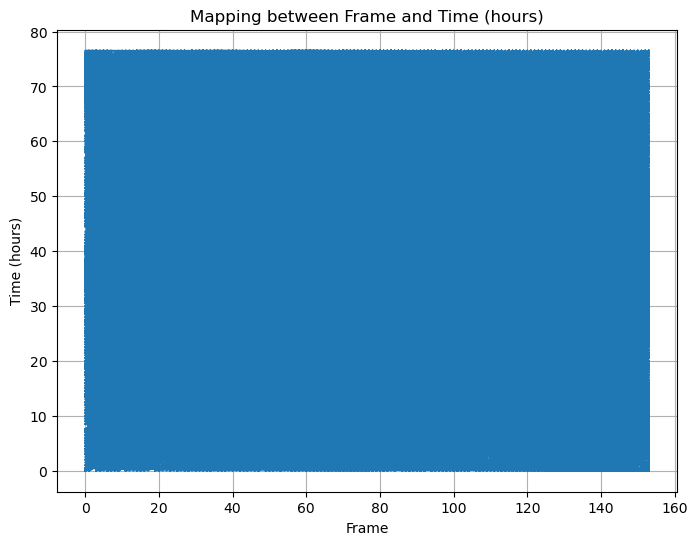

In [39]:
import matplotlib.pyplot as plt

# Filter out rows where 'Frame' or 'Time (hours)' are NaN
filtered_df = df.dropna(subset=['Frame', 'Time (hours)'])

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.plot(filtered_df['Frame'], filtered_df['Time (hours)'])
plt.xlabel('Frame')
plt.ylabel('Time (hours)')
plt.title('Mapping between Frame and Time (hours)')
plt.grid(True)

# Show the plot
plt.show()